<a href="https://colab.research.google.com/github/Digital1st/sol_price_model/blob/main/Tcn_sliding_window.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Dropout, Add, ReLU
import matplotlib.pyplot as plt

# Generate synthetic time series data (example with whole numbers)
data = np.array([11, 13, 17, 16, 20, 22, 27, 25, 30, 32])

# Sliding window function to prepare input and output for 2-step prediction
def create_sliding_window(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + forecast_horizon])  # 2-step prediction
    return np.array(X), np.array(y)

# Set parameters
window_size = 10
forecast_horizon = 2  # Predict 2 steps ahead

# Prepare the dataset
X, y = create_sliding_window(data, window_size, forecast_horizon)

# Reshape X to match the input shape for Conv1D (samples, time steps, features)
X = X[..., np.newaxis]

# Build the TCN model
def build_tcn(input_shape, num_blocks=4, filters=32, kernel_size=3):
    inputs = Input(shape=input_shape)
    x = inputs

    # Stack multiple residual blocks with increasing dilation rates
    for i in range(num_blocks):
        x = residual_block(x, filters, kernel_size, dilation_rate=2**i)
        x = Dropout(0.2)(x)

    x = Flatten()(x)
    outputs = Dense(forecast_horizon)(x)  # Predict two future values

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def residual_block(x, filters, kernel_size, dilation_rate):
    """A single TCN residual block."""
    conv1 = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    conv2 = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(conv1)
    shortcut = Conv1D(filters, 1, padding='same')(x)  # Match dimensions
    output = Add()([conv2, shortcut])
    output = ReLU()(output)
    return output

# Build the model
input_shape = (window_size, 1)
model = build_tcn(input_shape)

# Model summary
model.summary()

# Train the model
model.fit(X, y, epochs=20, batch_size=2)

# Make predictions using the model
predictions = model.predict(X)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(data)), data, label='True Values')
plt.plot(range(window_size, len(data)), predictions[:, 0], label='Predicted 1st Step', linestyle='--')
plt.plot(range(window_size, len(data)), predictions[:, 1], label='Predicted 2nd Step', linestyle='--')
plt.legend()
plt.title('True vs Predicted Time Series Values (2 Steps Ahead)')
plt.show()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 10, 32)         │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 10, 32)         │          3,104 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 10, 32)         │             64 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 10, 32)         │              0 │ conv1d_1[0][0],        │
│                           │                        │                │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 10, 32)         │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 10, 32)         │              0 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 10, 32)         │          3,104 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 10, 32)         │          3,104 │ conv1d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 10, 32)         │          1,056 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 10, 32)         │              0 │ conv1d_4[0][0],        │
│                           │                        │                │ conv1d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 10, 32)         │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 10, 32)         │              0 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 10, 32)         │          3,104 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 10, 32)         │          3,104 │ conv1d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 10, 32)         │          1,056 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 10, 32)         │              0 │ conv1d_7[0][0],        │
│                           │                        │                │ conv1d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 10, 32)         │              0 │ add_2[0][0]            │
├──────────────────────

 Total params: 25,730 (100.51 KB)

 Trainable params: 25,730 (100.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 320, but received input with shape (2, 32)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(2, 1), dtype=float32)
  • training=True
  • mask=None

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Dropout, Add, ReLU
import matplotlib.pyplot as plt

# Generate synthetic time series data (example with whole numbers)
data = np.array([11, 13, 17, 16, 20, 22, 27, 25, 30, 32])

# Sliding window function to prepare input and output for 2-step prediction
def create_sliding_window(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i + window_size])  # Take the window of the last 'window_size' time steps
        y.append(data[i + window_size:i + window_size + forecast_horizon])  # Predict the next 'forecast_horizon' steps
    return np.array(X), np.array(y)

# Set parameters
window_size = 10
forecast_horizon = 2  # Predict 2 steps ahead

# Prepare the dataset
X, y = create_sliding_window(data, window_size, forecast_horizon)

# Reshape X to match the input shape for Conv1D (samples, time steps, features)
X = X[..., np.newaxis]  # Adding a new axis for features (1 feature per time step)

# Build the TCN model
def build_tcn(input_shape, num_blocks=4, filters=32, kernel_size=3):
    inputs = Input(shape=input_shape)
    x = inputs

    # Stack multiple residual blocks with increasing dilation rates
    for i in range(num_blocks):
        x = residual_block(x, filters, kernel_size, dilation_rate=2**i)
        x = Dropout(0.2)(x)

    x = Flatten()(x)
    outputs = Dense(forecast_horizon)(x)  # Predict two future values

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def residual_block(x, filters, kernel_size, dilation_rate):
    """A single TCN residual block."""
    conv1 = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    conv2 = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(conv1)
    shortcut = Conv1D(filters, 1, padding='same')(x)  # Match dimensions
    output = Add()([conv2, shortcut])
    output = ReLU()(output)
    return output

# Build the model
input_shape = (window_size, 1)  # Input shape should be (10, 1)
model = build_tcn(input_shape)

# Model summary
model.summary()

# Train the model
model.fit(X, y, epochs=20, batch_size=2)

# Make predictions using the model
predictions = model.predict(X)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(data)), data, label='True Values')
plt.plot(range(window_size, len(data)), predictions[:, 0], label='Predicted 1st Step', linestyle='--')
plt.plot(range(window_size, len(data)), predictions[:, 1], label='Predicted 2nd Step', linestyle='--')
plt.legend()
plt.title('True vs Predicted Time Series Values (2 Steps Ahead)')
plt.show()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 10, 32)         │            128 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 10, 32)         │             64 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 10, 32)         │              0 │ conv1d_13[0][0],       │
│                           │                        │                │ conv1d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_4 (ReLU)            │ (None, 10, 32)         │              0 │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 10, 32)         │              0 │ re_lu_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_15 (Conv1D)        │ (None, 10, 32)         │          3,104 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_16 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)        │ (None, 10, 32)         │          1,056 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 10, 32)         │              0 │ conv1d_16[0][0],       │
│                           │                        │                │ conv1d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_5 (ReLU)            │ (None, 10, 32)         │              0 │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 10, 32)         │              0 │ re_lu_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_18 (Conv1D)        │ (None, 10, 32)         │          3,104 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_19 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_20 (Conv1D)        │ (None, 10, 32)         │          1,056 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 10, 32)         │              0 │ conv1d_19[0][0],       │
│                           │                        │                │ conv1d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_6 (ReLU)       

 Total params: 25,730 (100.51 KB)

 Trainable params: 25,730 (100.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "dense_1" is incompatible with the layer: expected axis -1 of input shape to have value 320, but received input with shape (2, 32)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(2, 1), dtype=float32)
  • training=True
  • mask=None

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Dropout, Add, ReLU
import matplotlib.pyplot as plt

# Generate synthetic time series data (example with whole numbers)
data = np.array([11, 13, 17, 16, 20, 22, 27, 25, 30, 32])

# Sliding window function to prepare input and output for 2-step prediction
def create_sliding_window(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i + window_size])  # Take the window of the last 'window_size' time steps
        y.append(data[i + window_size:i + window_size + forecast_horizon])  # Predict the next 'forecast_horizon' steps
    return np.array(X), np.array(y)

# Set parameters
window_size = 10
forecast_horizon = 2  # Predict 2 steps ahead

# Prepare the dataset
X, y = create_sliding_window(data, window_size, forecast_horizon)

# Reshape X to match the input shape for Conv1D (samples, time steps, features)
X = X[..., np.newaxis]  # Adding a new axis for features (1 feature per time step)

# Build the TCN model
def build_tcn(input_shape, num_blocks=4, filters=32, kernel_size=3):
    inputs = Input(shape=input_shape)
    x = inputs

    # Stack multiple residual blocks with increasing dilation rates
    for i in range(num_blocks):
        x = residual_block(x, filters, kernel_size, dilation_rate=2**i)
        x = Dropout(0.2)(x)

    x = Flatten()(x)
    # Change the number of units in the Dense layer to match the shape after flattening
    outputs = Dense(forecast_horizon)(x)  # Predict two future values

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def residual_block(x, filters, kernel_size, dilation_rate):
    """A single TCN residual block."""
    conv1 = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    conv2 = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(conv1)
    shortcut = Conv1D(filters, 1, padding='same')(x)  # Match dimensions
    output = Add()([conv2, shortcut])
    output = ReLU()(output)
    return output

# Build the model
input_shape = (window_size, 1)  # Input shape should be (10, 1)
model = build_tcn(input_shape)

# Model summary
model.summary()

# Train the model
model.fit(X, y, epochs=20, batch_size=2)

# Make predictions using the model
predictions = model.predict(X)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(data)), data, label='True Values')
plt.plot(range(window_size, len(data)), predictions[:, 0], label='Predicted 1st Step', linestyle='--')
plt.plot(range(window_size, len(data)), predictions[:, 1], label='Predicted 2nd Step', linestyle='--')
plt.legend()
plt.title('True vs Predicted Time Series Values (2 Steps Ahead)')
plt.show()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_24 (Conv1D)        │ (None, 10, 32)         │            128 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_25 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_26 (Conv1D)        │ (None, 10, 32)         │             64 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 10, 32)         │              0 │ conv1d_25[0][0],       │
│                           │                        │                │ conv1d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_8 (ReLU)            │ (None, 10, 32)         │              0 │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 10, 32)         │              0 │ re_lu_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_27 (Conv1D)        │ (None, 10, 32)         │          3,104 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_28 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_29 (Conv1D)        │ (None, 10, 32)         │          1,056 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 10, 32)         │              0 │ conv1d_28[0][0],       │
│                           │                        │                │ conv1d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_9 (ReLU)            │ (None, 10, 32)         │              0 │ add_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 10, 32)         │              0 │ re_lu_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_30 (Conv1D)        │ (None, 10, 32)         │          3,104 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_31 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_32 (Conv1D)        │ (None, 10, 32)         │          1,056 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 10, 32)         │              0 │ conv1d_31[0][0],       │
│                           │                        │                │ conv1d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_10 (ReLU)      

 Total params: 25,730 (100.51 KB)

 Trainable params: 25,730 (100.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "dense_2" is incompatible with the layer: expected axis -1 of input shape to have value 320, but received input with shape (2, 32)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(2, 1), dtype=float32)
  • training=True
  • mask=None

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()

# Add convolutional layers with residual connections (Add layer)
model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(10, 1)))  # First Conv1D layer
model.add(layers.Conv1D(32, 3, activation='relu'))  # Second Conv1D layer
model.add(layers.Add())  # Adding a residual connection between Conv1D layers
model.add(layers.ReLU())  # ReLU activation function
model.add(layers.Dropout(0.2))  # Dropout to avoid overfitting

# Add another set of convolutional layers with residual connections
model.add(layers.Conv1D(32, 3, activation='relu'))  # First Conv1D layer
model.add(layers.Conv1D(32, 3, activation='relu'))  # Second Conv1D layer
model.add(layers.Add())  # Residual connection
model.add(layers.ReLU())  # ReLU activation function
model.add(layers.Dropout(0.2))  # Dropout

# Add another set of convolutional layers with residual connections
model.add(layers.Conv1D(32, 3, activation='relu'))  # First Conv1D layer
model.add(layers.Conv1D(32, 3, activation='relu'))  # Second Conv1D layer
model.add(layers.Add())  # Residual connection
model.add(layers.ReLU())  # ReLU activation function
model.add(layers.Dropout(0.2))  # Dropout

# Flatten the output from Conv1D layers to feed it into Dense layers
model.add(layers.Flatten())

# Add Dense layer for classification
model.add(layers.Dense(2))  # Output layer with 2 units (for binary classification)

# Model summary
model.summary()

# Example data for training
import numpy as np

# Random data (replace with your actual data)
X = np.random.randn(100, 10, 1)  # 100 samples, each with 10 time steps and 1 feature
y = np.random.randint(2, size=(100,))  # 100 labels (binary classification)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=20, batch_size=2)

# Make predictions
predictions = model.predict(X)

# Print some predictions
print(predictions[:5])  # Print the first 5 predictions

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: A merge layer should be called on a list of inputs. Received: input_shape=(None, 6, 32) (not a list of shapes)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model with Input layer
input_layer = layers.Input(shape=(10, 1))  # Input layer

# First block of convolutions
x1 = layers.Conv1D(32, 3, activation='relu')(input_layer)
x2 = layers.Conv1D(32, 3, activation='relu')(x1)

# Residual connection (matching the shapes before adding)
x1_res = layers.Conv1D(32, 1)(input_layer)  # Matching the shape of x2
residual = layers.Add()([x2, x1_res])  # Adding the residual connection
x1_out = layers.ReLU()(residual)
x1_out = layers.Dropout(0.2)(x1_out)

# Second block of convolutions
x3 = layers.Conv1D(32, 3, activation='relu')(x1_out)
x4 = layers.Conv1D(32, 3, activation='relu')(x3)

# Residual connection (matching the shapes before adding)
x3_res = layers.Conv1D(32, 1)(x1_out)  # Matching the shape of x4
residual2 = layers.Add()([x4, x3_res])  # Adding the residual connection
x2_out = layers.ReLU()(residual2)
x2_out = layers.Dropout(0.2)(x2_out)

# Flattening and Dense layer
x3_out = layers.Flatten()(x2_out)
output = layers.Dense(2)(x3_out)

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Model summary
model.summary()

# Example data for training
import numpy as np

# Random data (replace with your actual data)
X = np.random.randn(100, 10, 1)  # 100 samples, each with 10 time steps and 1 feature
y = np.random.randint(2, size=(100,))  # 100 labels (binary classification)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=20, batch_size=2)

# Make predictions
predictions = model.predict(X)

# Print some predictions
print(predictions[:5])  # Print the first 5 predictions

ValueError: Inputs have incompatible shapes. Received shapes (6, 32) and (10, 32)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model with Input layer
input_layer = layers.Input(shape=(10, 1))  # Input layer

# First block of convolutions
x1 = layers.Conv1D(32, 3, activation='relu', padding='same')(input_layer)  # Padding to keep sequence length
x2 = layers.Conv1D(32, 3, activation='relu', padding='same')(x1)  # Padding to keep sequence length

# Residual connection (matching the shapes before adding)
x1_res = layers.Conv1D(32, 1, padding='same')(input_layer)  # Matching the shape of x2 with padding
residual = layers.Add()([x2, x1_res])  # Adding the residual connection
x1_out = layers.ReLU()(residual)
x1_out = layers.Dropout(0.2)(x1_out)

# Second block of convolutions
x3 = layers.Conv1D(32, 3, activation='relu', padding='same')(x1_out)  # Padding to keep sequence length
x4 = layers.Conv1D(32, 3, activation='relu', padding='same')(x3)  # Padding to keep sequence length

# Residual connection (matching the shapes before adding)
x3_res = layers.Conv1D(32, 1, padding='same')(x1_out)  # Matching the shape of x4 with padding
residual2 = layers.Add()([x4, x3_res])  # Adding the residual connection
x2_out = layers.ReLU()(residual2)
x2_out = layers.Dropout(0.2)(x2_out)

# Flattening and Dense layer
x3_out = layers.Flatten()(x2_out)
output = layers.Dense(2)(x3_out)

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Model summary
model.summary()

# Example data for training
import numpy as np

# Random data (replace with your actual data)
X = np.random.randn(100, 10, 1)  # 100 samples, each with 10 time steps and 1 feature
y = np.random.randint(2, size=(100,))  # 100 labels (binary classification)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=20, batch_size=2)

# Make predictions
predictions = model.predict(X)

# Print some predictions
print(predictions[:5])  # Print the first 5 predictions

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_44 (Conv1D)        │ (None, 10, 32)         │            128 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_45 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_46 (Conv1D)        │ (None, 10, 32)         │             64 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 10, 32)         │              0 │ conv1d_45[0][0],       │
│                           │                        │                │ conv1d_46[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_12 (ReLU)           │ (None, 10, 32)         │              0 │ add_15[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 10, 32)         │              0 │ re_lu_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_47 (Conv1D)        │ (None, 10, 32)         │          3,104 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_48 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_47[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_49 (Conv1D)        │ (None, 10, 32)         │          1,056 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 10, 32)         │              0 │ conv1d_48[0][0],       │
│                           │                        │                │ conv1d_49[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_13 (ReLU)           │ (None, 10, 32)         │              0 │ add_16[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 10, 32)         │              0 │ re_lu_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 320)            │              0 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 2)              │            642 │ flatten_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,202 (43.76 KB)

 Trainable params: 11,202 (43.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4821 - loss: 4.7163
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4612 - loss: 4.4305
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5995 - loss: 2.1506
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6563 - loss: 0.7389
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5417 - loss: 1.2222
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5266 - loss: 0.6931
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6276 - loss: 0.6931
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5435 - loss: 0.6931
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6456 - loss: 0.6931
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5980 - loss: 0.6931
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5684 - loss: 0.6931
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6066 - lo

In [ ]:
import yfinance as yf
import numpy as np
from tensorflow.keras import layers, models

# Fetch 30-minute interval data for Bitcoin (BTC) against USD
symbol = "BTC-USD"
data = yf.download(symbol, interval="30m", period="5d")  # Fetch 5 days of data with 30-minute interval

# Ensure we have enough data (at least 10 time steps for the model)
if len(data) < 10:
    raise ValueError("Not enough data fetched for the model.")

# Extract the 'Close' price to use as our feature
prices = data['Close'].values

# Prepare the data (reshape it into (num_samples, 10, 1))
X = []
y = []

# We will use the 'Close' price as the feature and predict the next price (simplified task)
for i in range(len(prices) - 10):
    X.append(prices[i:i + 10])  # Use 10 previous prices to predict the next one
    y.append(prices[i + 10])    # The next price will be the target (regression task)

# Convert to numpy arrays and reshape X to have 1 feature
X = np.array(X).reshape(-1, 10, 1)
y = np.array(y)

# Define the model with Input layer
input_layer = layers.Input(shape=(10, 1))  # Input layer

# First block of convolutions
x1 = layers.Conv1D(32, 3, activation='relu', padding='same')(input_layer)  # Padding to keep sequence length
x2 = layers.Conv1D(32, 3, activation='relu', padding='same')(x1)  # Padding to keep sequence length

# Residual connection (matching the shapes before adding)
x1_res = layers.Conv1D(32, 1, padding='same')(input_layer)  # Matching the shape of x2 with padding
residual = layers.Add()([x2, x1_res])  # Adding the residual connection
x1_out = layers.ReLU()(residual)
x1_out = layers.Dropout(0.2)(x1_out)

# Second block of convolutions
x3 = layers.Conv1D(32, 3, activation='relu', padding='same')(x1_out)  # Padding to keep sequence length
x4 = layers.Conv1D(32, 3, activation='relu', padding='same')(x3)  # Padding to keep sequence length

# Residual connection (matching the shapes before adding)
x3_res = layers.Conv1D(32, 1, padding='same')(x1_out)  # Matching the shape of x4 with padding
residual2 = layers.Add()([x4, x3_res])  # Adding the residual connection
x2_out = layers.ReLU()(residual2)
x2_out = layers.Dropout(0.2)(x2_out)

# Flattening and Dense layer
x3_out = layers.Flatten()(x2_out)
output = layers.Dense(1)(x3_out)  # Predicting the next price (regression task)

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
model.fit(X, y, epochs=20, batch_size=2)

# Make predictions
predictions = model.predict(X)

# Print some predictions
print(predictions[:5])  # Print the first 5 predictions

[*********************100%***********************]  1 of 1 completed


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_50 (Conv1D)        │ (None, 10, 32)         │            128 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_51 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_50[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_52 (Conv1D)        │ (None, 10, 32)         │             64 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_17 (Add)              │ (None, 10, 32)         │              0 │ conv1d_51[0][0],       │
│                           │                        │                │ conv1d_52[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_14 (ReLU)           │ (None, 10, 32)         │              0 │ add_17[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 10, 32)         │              0 │ re_lu_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_53 (Conv1D)        │ (None, 10, 32)         │          3,104 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_54 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_53[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_55 (Conv1D)        │ (None, 10, 32)         │          1,056 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 10, 32)         │              0 │ conv1d_54[0][0],       │
│                           │                        │                │ conv1d_55[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_15 (ReLU)           │ (None, 10, 32)         │              0 │ add_18[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 10, 32)         │              0 │ re_lu_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 320)            │              0 │ dropout_15[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │            321 │ flatten_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,881 (42.50 KB)

 Trainable params: 10,881 (42.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1990979072.0000 - mae: 32433.1016
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 292064352.0000 - mae: 13652.1992
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 224231536.0000 - mae: 12037.6689
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141869056.0000 - mae: 9198.6963
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133721728.0000 - mae: 9637.5742
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109256888.0000 - mae: 8616.4004
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85162608.0000 - mae: 7549.7583
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97519304.0000 - mae: 7881.8643
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121267192.0000 - mae: 9047.4873
Epoch 10/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86027248.0000 - mae: 7801.0400
Epoch 11/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76364208.0000 - m

In [ ]:

import yfinance as yf
import numpy as np
from tensorflow.keras import layers, models

# Fetch 30-minute interval data for Ethereum (ETH) against USD
symbol = "ETH-USD"
data = yf.download(symbol, interval="30m", period="5d")  # Fetch 5 days of data with 30-minute interval

# Ensure we have enough data (at least 10 time steps for the model)
if len(data) < 10:
    raise ValueError("Not enough data fetched for the model.")

# Extract the 'Close' price to use as our feature
prices = data['Close'].values

# Prepare the data (reshape it into (num_samples, 10, 1))
X = []
y = []

# We will use the 'Close' price as the feature and predict the next price (simplified task)
for i in range(len(prices) - 10):
    X.append(prices[i:i + 10])  # Use 10 previous prices to predict the next one
    y.append(prices[i + 10])    # The next price will be the target (regression task)

# Convert to numpy arrays and reshape X to have 1 feature
X = np.array(X).reshape(-1, 10, 1)
y = np.array(y)

# Define the model with Input layer
input_layer = layers.Input(shape=(10, 1))  # Input layer

# First block of convolutions
x1 = layers.Conv1D(32, 3, activation='relu', padding='same')(input_layer)  # Padding to keep sequence length
x2 = layers.Conv1D(32, 3, activation='relu', padding='same')(x1)  # Padding to keep sequence length

# Residual connection (matching the shapes before adding)
x1_res = layers.Conv1D(32, 1, padding='same')(input_layer)  # Matching the shape of x2 with padding
residual = layers.Add()([x2, x1_res])  # Adding the residual connection
x1_out = layers.ReLU()(residual)
x1_out = layers.Dropout(0.2)(x1_out)

# Second block of convolutions
x3 = layers.Conv1D(32, 3, activation='relu', padding='same')(x1_out)  # Padding to keep sequence length
x4 = layers.Conv1D(32, 3, activation='relu', padding='same')(x3)  # Padding to keep sequence length

# Residual connection (matching the shapes before adding)
x3_res = layers.Conv1D(32, 1, padding='same')(x1_out)  # Matching the shape of x4 with padding
residual2 = layers.Add()([x4, x3_res])  # Adding the residual connection
x2_out = layers.ReLU()(residual2)
x2_out = layers.Dropout(0.2)(x2_out)

# Flattening and Dense layer
x3_out = layers.Flatten()(x2_out)
output = layers.Dense(1)(x3_out)  # Predicting the next price (regression task)

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
model.fit(X, y, epochs=20, batch_size=2)

# Make predictions
predictions = model.predict(X)

# Print some predictions
print(predictions[:5])  # Print the first 5 predictions

[*********************100%***********************]  1 of 1 completed


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_56 (Conv1D)        │ (None, 10, 32)         │            128 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_57 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_56[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_58 (Conv1D)        │ (None, 10, 32)         │             64 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_19 (Add)              │ (None, 10, 32)         │              0 │ conv1d_57[0][0],       │
│                           │                        │                │ conv1d_58[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_16 (ReLU)           │ (None, 10, 32)         │              0 │ add_19[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 10, 32)         │              0 │ re_lu_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_59 (Conv1D)        │ (None, 10, 32)         │          3,104 │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_60 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_59[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_61 (Conv1D)        │ (None, 10, 32)         │          1,056 │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_20 (Add)              │ (None, 10, 32)         │              0 │ conv1d_60[0][0],       │
│                           │                        │                │ conv1d_61[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_17 (ReLU)           │ (None, 10, 32)         │              0 │ add_20[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 10, 32)         │              0 │ re_lu_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 320)            │              0 │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            321 │ flatten_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,881 (42.50 KB)

 Trainable params: 10,881 (42.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3758876.0000 - mae: 1329.5802
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 317366.5625 - mae: 440.2981
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 221695.7344 - mae: 370.0190
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 183147.7031 - mae: 344.8390
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150504.6250 - mae: 311.9742
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 206953.5469 - mae: 371.4097
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132894.2812 - mae: 282.1717
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121176.1953 - mae: 277.2386
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140616.3594 - mae: 289.4818
Epoch 10/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123880.4219 - mae: 297.7815
Epoch 11/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 94517.5391 - mae: 240.6086
Epoch 12/20
113/113 ━━━━━━━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[3268.6487]
 [3267.1487]
 [3261.9868]
 [3259.4648]
 [3255.9446]]


[*********************100%***********************]  1 of 1 completed


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_62 (Conv1D)        │ (None, 10, 32)         │            128 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_63 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_62[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_64 (Conv1D)        │ (None, 10, 32)         │             64 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_21 (Add)              │ (None, 10, 32)         │              0 │ conv1d_63[0][0],       │
│                           │                        │                │ conv1d_64[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_18 (ReLU)           │ (None, 10, 32)         │              0 │ add_21[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 10, 32)         │              0 │ re_lu_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_65 (Conv1D)        │ (None, 10, 32)         │          3,104 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_66 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_65[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_67 (Conv1D)        │ (None, 10, 32)         │          1,056 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_22 (Add)              │ (None, 10, 32)         │              0 │ conv1d_66[0][0],       │
│                           │                        │                │ conv1d_67[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_19 (ReLU)           │ (None, 10, 32)         │              0 │ add_22[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 10, 32)         │              0 │ re_lu_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 320)            │              0 │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │            321 │ flatten_6[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,881 (42.50 KB)

 Trainable params: 10,881 (42.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1223703.7500 - mae: 835.4086
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 389331.1250 - mae: 463.9073
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 397177.6562 - mae: 481.2473
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 236313.3438 - mae: 397.7642
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 200810.3125 - mae: 361.9270
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 168303.7656 - mae: 336.7821
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 174182.9688 - mae: 337.7700
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160310.0469 - mae: 313.2970
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116241.1484 - mae: 280.6071
Epoch 10/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109086.4453 - mae: 260.3068
Epoch 11/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101062.0859 - mae: 253.8084
Epoch 12/20
113/113 ━━━━━━━━━

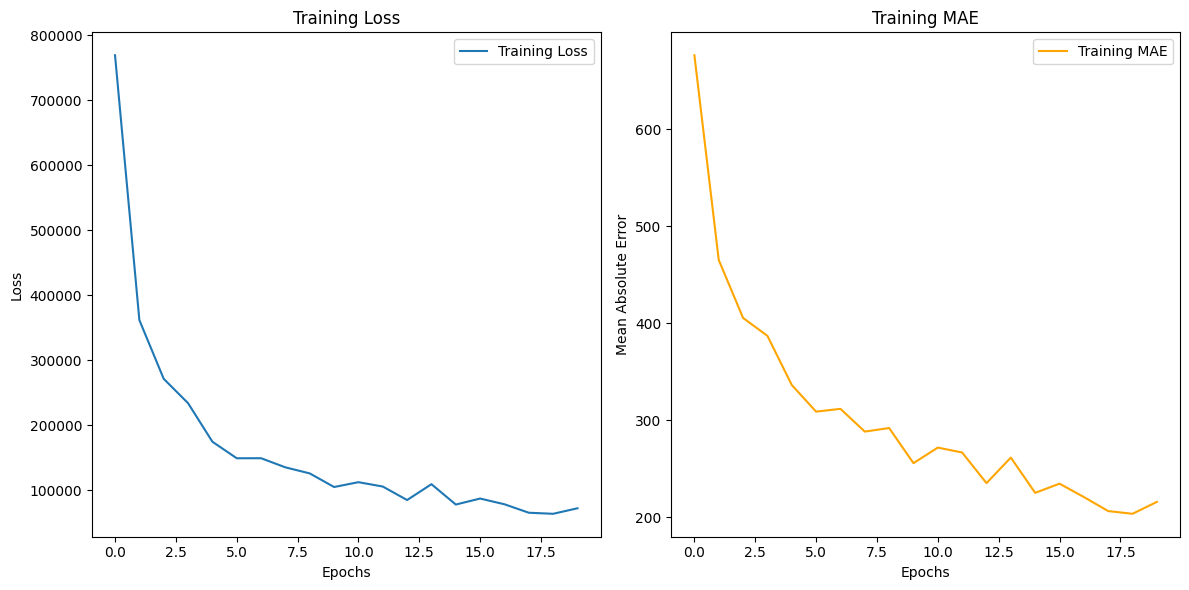

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[3153.5374]
 [3150.4553]
 [3148.2424]
 [3143.6814]
 [3142.6604]]


In [ ]:

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Fetch 30-minute interval data for Ethereum (ETH) against USD
symbol = "ETH-USD"
data = yf.download(symbol, interval="30m", period="5d")  # Fetch 5 days of data with 30-minute interval

# Ensure we have enough data (at least 10 time steps for the model)
if len(data) < 10:
    raise ValueError("Not enough data fetched for the model.")

# Extract the 'Close' price to use as our feature
prices = data['Close'].values

# Prepare the data (reshape it into (num_samples, 10, 1))
X = []
y = []

# We will use the 'Close' price as the feature and predict the next price (simplified task)
for i in range(len(prices) - 10):
    X.append(prices[i:i + 10])  # Use 10 previous prices to predict the next one
    y.append(prices[i + 10])    # The next price will be the target (regression task)

# Convert to numpy arrays and reshape X to have 1 feature
X = np.array(X).reshape(-1, 10, 1)
y = np.array(y)

# Define the model with Input layer
input_layer = layers.Input(shape=(10, 1))  # Input layer

# First block of convolutions
x1 = layers.Conv1D(32, 3, activation='relu', padding='same')(input_layer)  # Padding to keep sequence length
x2 = layers.Conv1D(32, 3, activation='relu', padding='same')(x1)  # Padding to keep sequence length

# Residual connection (matching the shapes before adding)
x1_res = layers.Conv1D(32, 1, padding='same')(input_layer)  # Matching the shape of x2 with padding
residual = layers.Add()([x2, x1_res])  # Adding the residual connection
x1_out = layers.ReLU()(residual)
x1_out = layers.Dropout(0.2)(x1_out)

# Second block of convolutions
x3 = layers.Conv1D(32, 3, activation='relu', padding='same')(x1_out)  # Padding to keep sequence length
x4 = layers.Conv1D(32, 3, activation='relu', padding='same')(x3)  # Padding to keep sequence length

# Residual connection (matching the shapes before adding)
x3_res = layers.Conv1D(32, 1, padding='same')(x1_out)  # Matching the shape of x4 with padding
residual2 = layers.Add()([x4, x3_res])  # Adding the residual connection
x2_out = layers.ReLU()(residual2)
x2_out = layers.Dropout(0.2)(x2_out)

# Flattening and Dense layer
x3_out = layers.Flatten()(x2_out)
output = layers.Dense(1)(x3_out)  # Predicting the next price (regression task)

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model and capture the training history
history = model.fit(X, y, epochs=20, batch_size=2)

# Plotting the training loss and MAE
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', color='orange')
plt.title('Training MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Make predictions
predictions = model.predict(X)

# Print some predictions
print(predictions[:5])  # Print the first 5 predictions

[*********************100%***********************]  1 of 1 completed


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_68 (Conv1D)        │ (None, 10, 64)         │            256 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_69 (Conv1D)        │ (None, 10, 64)         │         12,352 │ conv1d_68[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_70 (Conv1D)        │ (None, 10, 64)         │            128 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_23 (Add)              │ (None, 10, 64)         │              0 │ conv1d_69[0][0],       │
│                           │                        │                │ conv1d_70[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_20 (ReLU)           │ (None, 10, 64)         │              0 │ add_23[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 10, 64)         │              0 │ re_lu_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_71 (Conv1D)        │ (None, 10, 64)         │         12,352 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_72 (Conv1D)        │ (None, 10, 64)         │         12,352 │ conv1d_71[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_73 (Conv1D)        │ (None, 10, 64)         │          4,160 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_24 (Add)              │ (None, 10, 64)         │              0 │ conv1d_72[0][0],       │
│                           │                        │                │ conv1d_73[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_21 (ReLU)           │ (None, 10, 64)         │              0 │ add_24[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 10, 64)         │              0 │ re_lu_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 640)            │              0 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │            641 │ flatten_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 42,241 (165.00 KB)

 Trainable params: 42,241 (165.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4406887.0000 - mae: 1515.0942 - val_loss: 103789.8984 - val_mae: 320.9989
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 358773.2812 - mae: 475.7260 - val_loss: 426862.5625 - val_mae: 652.7826
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 325031.5000 - mae: 466.1353 - val_loss: 201827.0469 - val_mae: 448.4145
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 318862.3438 - mae: 446.9991 - val_loss: 185996.7969 - val_mae: 430.3871
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 241427.3594 - mae: 400.7332 - val_loss: 49147.5391 - val_mae: 219.9210
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 180736.2500 - mae: 361.5029 - val_loss: 23729.2129 - val_mae: 151.4926
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 191556.8125 - mae: 357.7832 - val_loss: 265479.6875 - val_mae: 514.4942
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 158050.8750 - mae: 322.2613 - va

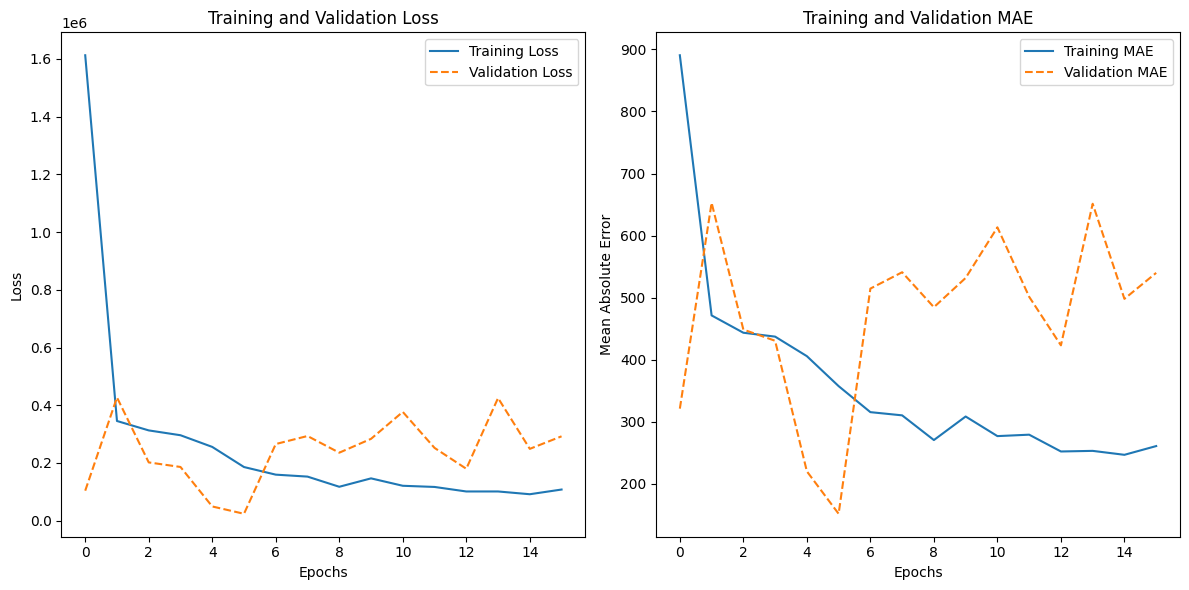

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[3677.4368]
 [3675.8872]
 [3670.1753]
 [3667.943 ]
 [3665.3044]]


In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Fetch 30-minute interval data for Ethereum (ETH) against USD
symbol = "ETH-USD"
data = yf.download(symbol, interval="30m", period="5d")  # Fetch 5 days of data with 30-minute interval

# Ensure we have enough data (at least 10 time steps for the model)
if len(data) < 10:
    raise ValueError("Not enough data fetched for the model.")

# Extract the 'Close' price to use as our feature
prices = data['Close'].values

# Prepare the data (reshape it into (num_samples, 10, 1))
X = []
y = []

# We will use the 'Close' price as the feature and predict the next price (simplified task)
for i in range(len(prices) - 10):
    X.append(prices[i:i + 10])  # Use 10 previous prices to predict the next one
    y.append(prices[i + 10])    # The next price will be the target (regression task)

# Convert to numpy arrays and reshape X to have 1 feature
X = np.array(X).reshape(-1, 10, 1)
y = np.array(y)

# Define the model with Input layer
input_layer = layers.Input(shape=(10, 1))  # Input layer

# First block of convolutions
x1 = layers.Conv1D(64, 3, activation='relu', padding='same')(input_layer)  # Increased filters
x2 = layers.Conv1D(64, 3, activation='relu', padding='same')(x1)  # Increased filters

# Residual connection (matching the shapes before adding)
x1_res = layers.Conv1D(64, 1, padding='same')(input_layer)  # Matching the shape of x2 with padding
residual = layers.Add()([x2, x1_res])  # Adding the residual connection
x1_out = layers.ReLU()(residual)
x1_out = layers.Dropout(0.3)(x1_out)  # Increased dropout to prevent overfitting

# Second block of convolutions
x3 = layers.Conv1D(64, 3, activation='relu', padding='same')(x1_out)  # Increased filters
x4 = layers.Conv1D(64, 3, activation='relu', padding='same')(x3)  # Increased filters

# Residual connection (matching the shapes before adding)
x3_res = layers.Conv1D(64, 1, padding='same')(x1_out)  # Matching the shape of x4 with padding
residual2 = layers.Add()([x4, x3_res])  # Adding the residual connection
x2_out = layers.ReLU()(residual2)
x2_out = layers.Dropout(0.3)(x2_out)  # Increased dropout to prevent overfitting

# Flattening and Dense layer
x3_out = layers.Flatten()(x2_out)
output = layers.Dense(1)(x3_out)  # Predicting the next price (regression task)

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Model summary
model.summary()

# Compile the model with adjusted learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model and capture the training history
history = model.fit(X, y, epochs=50, batch_size=2, validation_split=0.2, callbacks=[early_stopping])

# Plotting the training loss and MAE
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Make predictions
predictions = model.predict(X)

# Print some predictions
print(predictions[:5])  # Print the first 5 predictions

[*********************100%***********************]  1 of 1 completed


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_74 (Conv1D)        │ (None, 10, 128)        │            512 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 10, 128)        │            512 │ conv1d_74[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_75 (Conv1D)        │ (None, 10, 128)        │         49,280 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 10, 128)        │            512 │ conv1d_75[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_76 (Conv1D)        │ (None, 10, 128)        │            256 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_25 (Add)              │ (None, 10, 128)        │              0 │ batch_normalization_1… │
│                           │                        │                │ conv1d_76[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_22 (ReLU)           │ (None, 10, 128)        │              0 │ add_25[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 10, 128)        │              0 │ re_lu_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_77 (Conv1D)        │ (None, 10, 128)        │         49,280 │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 10, 128)        │            512 │ conv1d_77[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_78 (Conv1D)        │ (None, 10, 128)        │         49,280 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 10, 128)        │            512 │ conv1d_78[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_79 (Conv1D)        │ (None, 10, 128)        │         16,512 │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_26 (Add)              │ (None, 10, 128)        │              0 │ batch_normalization_3… │
│                           │                        │                │ conv1d_79[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_23 (ReLU)           │ (None, 10, 128)        │              0 │ add_26[0][0]           │
├──────────────────────

 Total params: 168,449 (658.00 KB)

 Trainable params: 167,425 (654.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 9591445.0000 - mae: 3038.3047 - val_loss: 2133268.2500 - val_mae: 1460.2760
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1089564.1250 - mae: 907.2339 - val_loss: 69071.3281 - val_mae: 261.2947
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 510082.4062 - mae: 598.3945 - val_loss: 2801.3179 - val_mae: 47.7251
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 172227.5312 - mae: 338.8629 - val_loss: 160760.8125 - val_mae: 399.9628
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 148828.3281 - mae: 305.7352 - val_loss: 81951.8438 - val_mae: 284.8933
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 140931.6562 - mae: 290.6682 - val_loss: 46238.0859 - val_mae: 213.1937
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 166969.4062 - mae: 330.5033 - val_loss: 84259.1016 - val_mae: 288.9151
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 125589.5078 - mae:

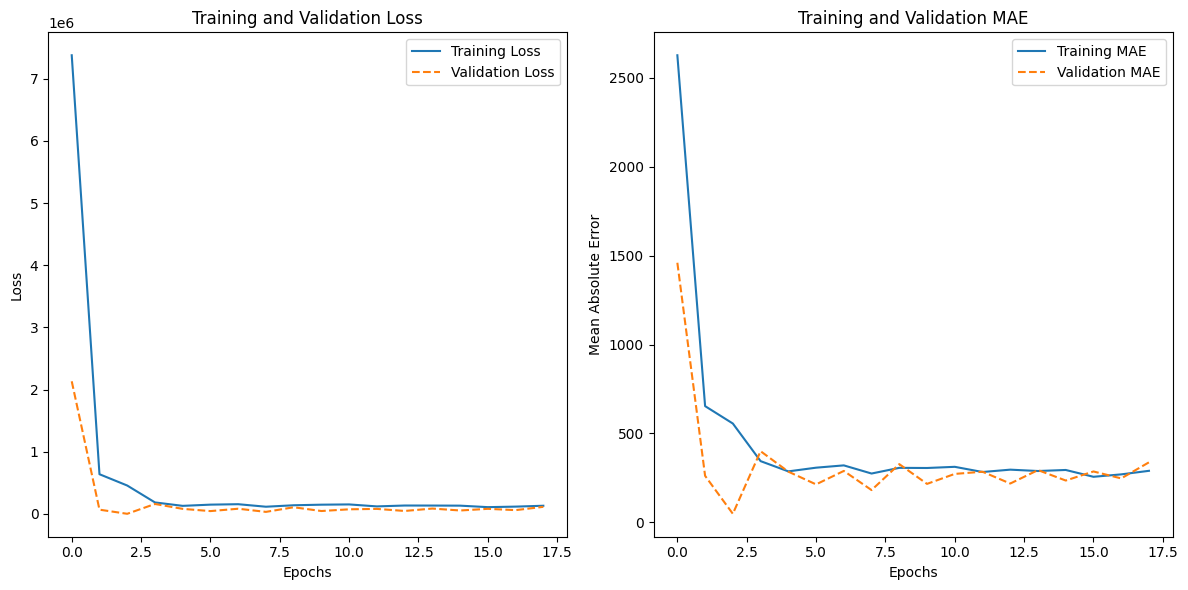

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
[[3802.5928]
 [3801.2847]
 [3795.6975]
 [3792.7722]
 [3789.6694]]


In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

# Fetch 30-minute interval data for Ethereum (ETH) against USD
symbol = "ETH-USD"
data = yf.download(symbol, interval="30m", period="5d")  # Fetch 5 days of data with 30-minute interval

# Ensure we have enough data (at least 10 time steps for the model)
if len(data) < 10:
    raise ValueError("Not enough data fetched for the model.")

# Extract the 'Close' price to use as our feature
prices = data['Close'].values

# Prepare the data (reshape it into (num_samples, 10, 1))
X = []
y = []

# We will use the 'Close' price as the feature and predict the next price (simplified task)
for i in range(len(prices) - 10):
    X.append(prices[i:i + 10])  # Use 10 previous prices to predict the next one
    y.append(prices[i + 10])    # The next price will be the target (regression task)

# Convert to numpy arrays and reshape X to have 1 feature
X = np.array(X).reshape(-1, 10, 1)
y = np.array(y)

# Define the model with Input layer
input_layer = layers.Input(shape=(10, 1))  # Input layer

# First block of convolutions
x1 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(input_layer)  # Increased filters and L2 regularization
x1 = BatchNormalization()(x1)  # BatchNormalization after the Conv1D layer
x2 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x1)  # Increased filters and L2 regularization
x2 = BatchNormalization()(x2)  # BatchNormalization after the Conv1D layer

# Residual connection (matching the shapes before adding)
x1_res = layers.Conv1D(128, 1, padding='same', kernel_regularizer=l2(0.01))(input_layer)  # Matching the shape of x2 with padding
residual = layers.Add()([x2, x1_res])  # Adding the residual connection
x1_out = layers.ReLU()(residual)
x1_out = layers.Dropout(0.3)(x1_out)  # Increased dropout to prevent overfitting

# Second block of convolutions
x3 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x1_out)  # Increased filters and L2 regularization
x3 = BatchNormalization()(x3)  # BatchNormalization after the Conv1D layer
x4 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x3)  # Increased filters and L2 regularization
x4 = BatchNormalization()(x4)  # BatchNormalization after the Conv1D layer

# Residual connection (matching the shapes before adding)
x3_res = layers.Conv1D(128, 1, padding='same', kernel_regularizer=l2(0.01))(x1_out)  # Matching the shape of x4 with padding
residual2 = layers.Add()([x4, x3_res])  # Adding the residual connection
x2_out = layers.ReLU()(residual2)
x2_out = layers.Dropout(0.3)(x2_out)  # Increased dropout to prevent overfitting

# Flattening and Dense layer
x3_out = layers.Flatten()(x2_out)
output = layers.Dense(1)(x3_out)  # Predicting the next price (regression task)

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Model summary
model.summary()

# Compile the model with adjusted learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model and capture the training history
history = model.fit(X, y, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Plotting the training loss and MAE
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Make predictions
predictions = model.predict(X)

# Print some predictions
print(predictions[:5])  # Print the first 5 predictions

[*********************100%***********************]  1 of 1 completed


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_80 (Conv1D)        │ (None, 10, 128)        │            512 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 10, 128)        │            512 │ conv1d_80[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_81 (Conv1D)        │ (None, 10, 128)        │         49,280 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 10, 128)        │            512 │ conv1d_81[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_82 (Conv1D)        │ (None, 10, 128)        │            256 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_27 (Add)              │ (None, 10, 128)        │              0 │ batch_normalization_5… │
│                           │                        │                │ conv1d_82[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_24 (ReLU)           │ (None, 10, 128)        │              0 │ add_27[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 10, 128)        │              0 │ re_lu_24[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_83 (Conv1D)        │ (None, 10, 128)        │         49,280 │ dropout_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 10, 128)        │            512 │ conv1d_83[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_84 (Conv1D)        │ (None, 10, 128)        │         49,280 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 10, 128)        │            512 │ conv1d_84[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_85 (Conv1D)        │ (None, 10, 128)        │         16,512 │ dropout_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_28 (Add)              │ (None, 10, 128)        │              0 │ batch_normalization_7… │
│                           │                        │                │ conv1d_85[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_25 (ReLU)           │ (None, 10, 128)        │              0 │ add_28[0][0]           │
├──────────────────────

 Total params: 168,449 (658.00 KB)

 Trainable params: 167,425 (654.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 9178778.0000 - mae: 2958.7800 - val_loss: 1621617.7500 - val_mae: 1273.1008
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 820940.9375 - mae: 764.7888 - val_loss: 173922.5156 - val_mae: 416.0920
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 481166.1250 - mae: 595.6182 - val_loss: 2230.1699 - val_mae: 42.5830
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 179634.1875 - mae: 352.2289 - val_loss: 171441.1719 - val_mae: 413.1010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 181605.5312 - mae: 333.2214 - val_loss: 47827.1953 - val_mae: 216.8943
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 144841.3281 - mae: 302.5785 - val_loss: 59247.2070 - val_mae: 241.7934
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 122329.1484 - mae: 287.5746 - val_loss: 67528.0469 - val_mae: 258.3520
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 133184.8438 - mae:

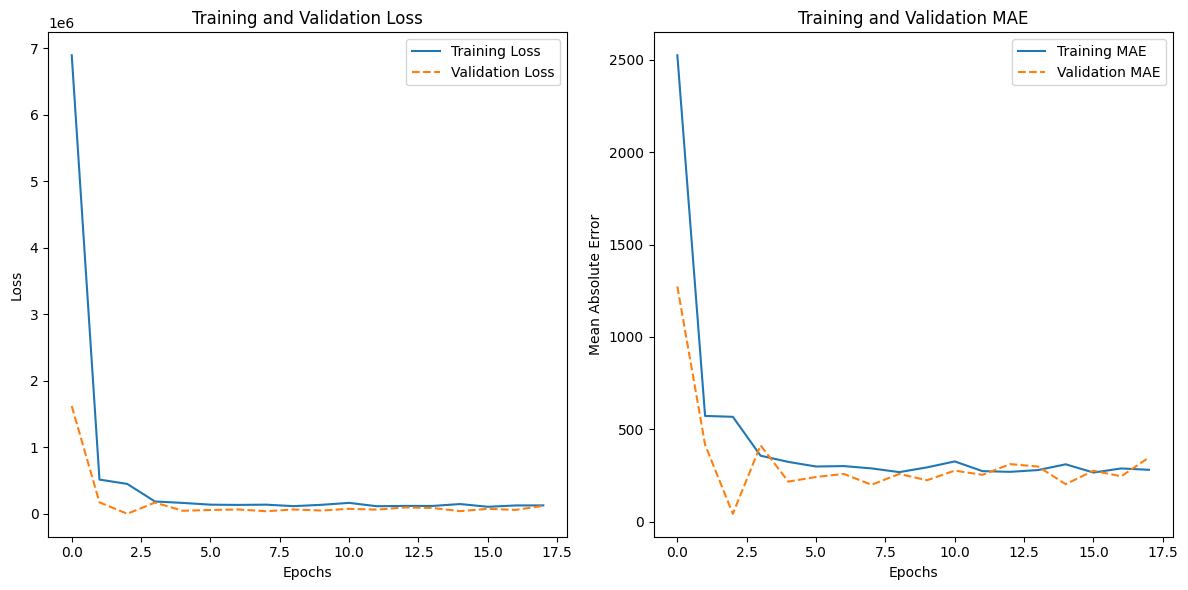

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
[[3808.4067]
 [3809.4302]
 [3802.9102]
 [3796.9817]
 [3796.9526]]


<ipython-input-19-722d8c16f4a1>:120: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


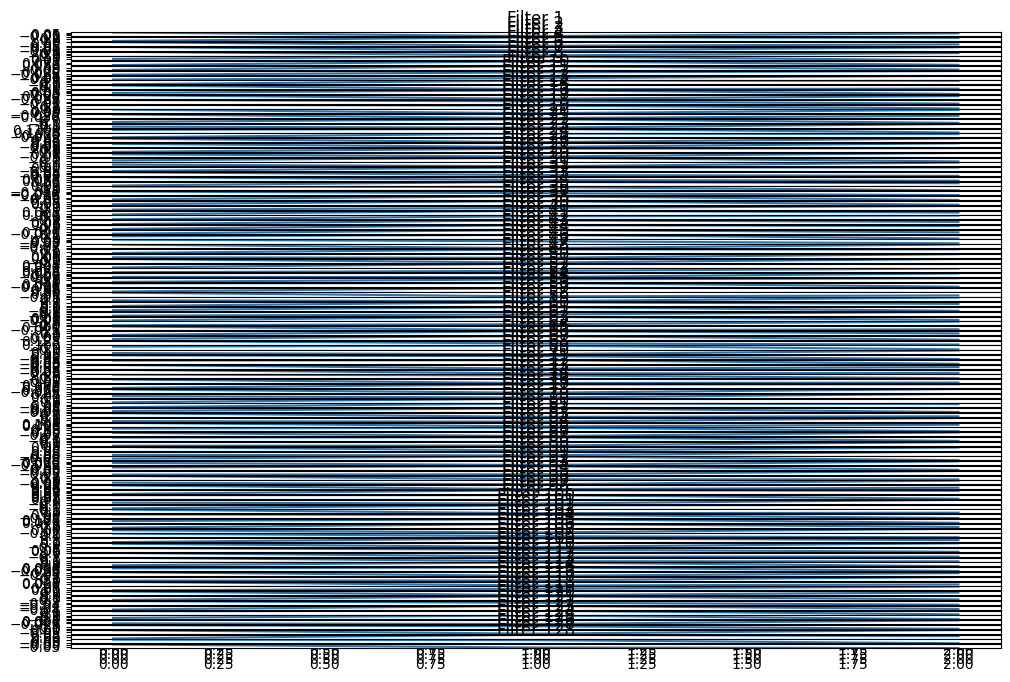

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


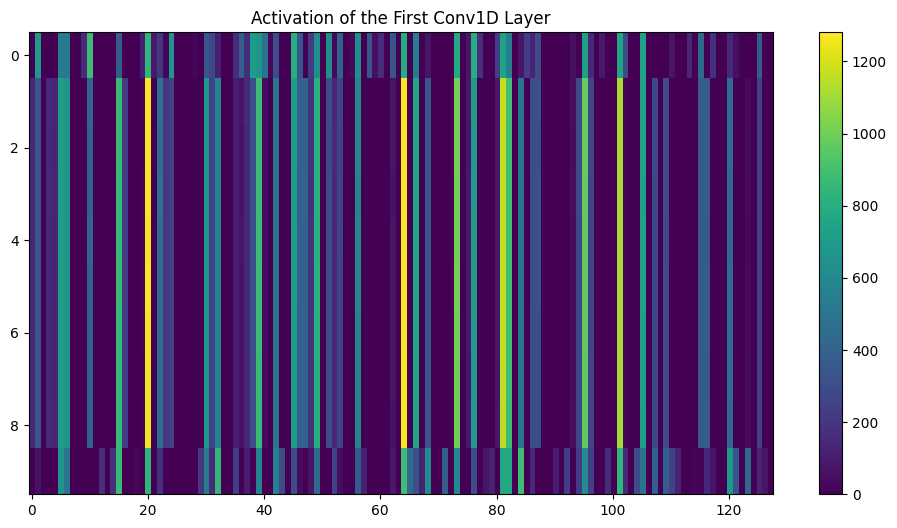

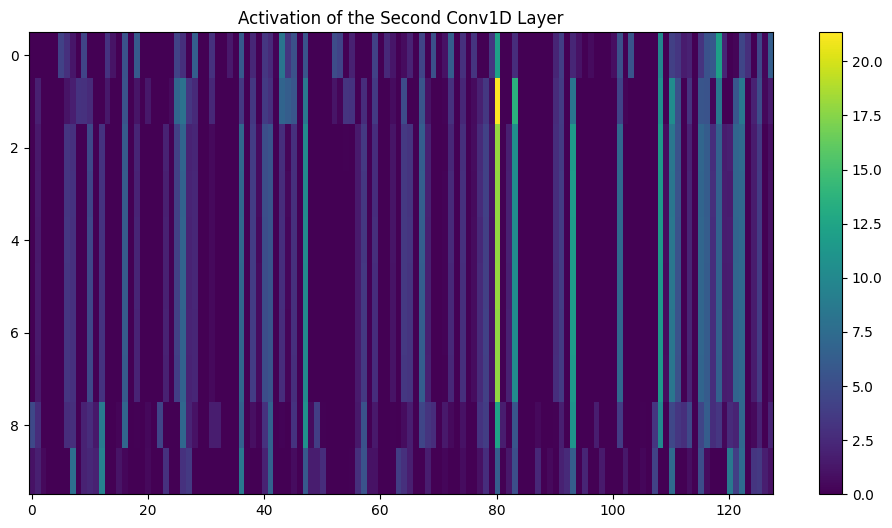

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf

# Fetch 30-minute interval data for Ethereum (ETH) against USD
symbol = "ETH-USD"
data = yf.download(symbol, interval="30m", period="5d")  # Fetch 5 days of data with 30-minute interval

# Ensure we have enough data (at least 10 time steps for the model)
if len(data) < 10:
    raise ValueError("Not enough data fetched for the model.")

# Extract the 'Close' price to use as our feature
prices = data['Close'].values

# Prepare the data (reshape it into (num_samples, 10, 1))
X = []
y = []

# We will use the 'Close' price as the feature and predict the next price (simplified task)
for i in range(len(prices) - 10):
    X.append(prices[i:i + 10])  # Use 10 previous prices to predict the next one
    y.append(prices[i + 10])    # The next price will be the target (regression task)

# Convert to numpy arrays and reshape X to have 1 feature
X = np.array(X).reshape(-1, 10, 1)
y = np.array(y)

# Define the model with Input layer
input_layer = layers.Input(shape=(10, 1))  # Input layer

# First block of convolutions
x1 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(input_layer)  # Increased filters and L2 regularization
x1 = BatchNormalization()(x1)  # BatchNormalization after the Conv1D layer
x2 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x1)  # Increased filters and L2 regularization
x2 = BatchNormalization()(x2)  # BatchNormalization after the Conv1D layer

# Residual connection (matching the shapes before adding)
x1_res = layers.Conv1D(128, 1, padding='same', kernel_regularizer=l2(0.01))(input_layer)  # Matching the shape of x2 with padding
residual = layers.Add()([x2, x1_res])  # Adding the residual connection
x1_out = layers.ReLU()(residual)
x1_out = layers.Dropout(0.3)(x1_out)  # Increased dropout to prevent overfitting

# Second block of convolutions
x3 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x1_out)  # Increased filters and L2 regularization
x3 = BatchNormalization()(x3)  # BatchNormalization after the Conv1D layer
x4 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x3)  # Increased filters and L2 regularization
x4 = BatchNormalization()(x4)  # BatchNormalization after the Conv1D layer

# Residual connection (matching the shapes before adding)
x3_res = layers.Conv1D(128, 1, padding='same', kernel_regularizer=l2(0.01))(x1_out)  # Matching the shape of x4 with padding
residual2 = layers.Add()([x4, x3_res])  # Adding the residual connection
x2_out = layers.ReLU()(residual2)
x2_out = layers.Dropout(0.3)(x2_out)  # Increased dropout to prevent overfitting

# Flattening and Dense layer
x3_out = layers.Flatten()(x2_out)
output = layers.Dense(1)(x3_out)  # Predicting the next price (regression task)

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Model summary
model.summary()

# Compile the model with adjusted learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model and capture the training history
history = model.fit(X, y, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Plotting the training loss and MAE
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Make predictions
predictions = model.predict(X)

# Print some predictions
print(predictions[:5])  # Print the first 5 predictions

# Visualize the learned filters of the first Conv1D layer
filters = model.layers[1].get_weights()[0]  # First Conv1D layer weights
num_filters = filters.shape[2]

plt.figure(figsize=(12, 8))
for i in range(num_filters):
    plt.subplot(num_filters, 1, i + 1)
    plt.plot(filters[:, 0, i])  # Plot each filter's weights
    plt.title(f"Filter {i + 1}")
plt.tight_layout()
plt.show()

# Visualizing activations for a sample input (e.g., the first data point)
sample_input = np.expand_dims(X[0], axis=0)  # Take the first sample input

# Create a new model to get intermediate activations
activation_model = models.Model(inputs=model.input, outputs=[layer.output for layer in model.layers])

# Get activations
activations = activation_model.predict(sample_input)

# Plot activations of the first convolution layer
activation_layer_1 = activations[1]  # The output of the first Conv1D layer
plt.figure(figsize=(12, 6))
plt.imshow(activation_layer_1[0], aspect='auto', cmap='viridis')
plt.title('Activation of the First Conv1D Layer')
plt.colorbar()
plt.show()

# Plot activations of the second convolution layer
activation_layer_2 = activations[3]  # The output of the second Conv1D layer
plt.figure(figsize=(12, 6))
plt.imshow(activation_layer_2[0], aspect='auto', cmap='viridis')
plt.title('Activation of the Second Conv1D Layer')
plt.colorbar()
plt.show()

[*********************100%***********************]  1 of 1 completed


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_86 (Conv1D)        │ (None, 10, 32)         │            128 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 10, 32)         │            128 │ conv1d_86[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_87 (Conv1D)        │ (None, 10, 32)         │          3,104 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 10, 32)         │            128 │ conv1d_87[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_88 (Conv1D)        │ (None, 10, 32)         │             64 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_29 (Add)              │ (None, 10, 32)         │              0 │ batch_normalization_9… │
│                           │                        │                │ conv1d_88[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_26 (ReLU)           │ (None, 10, 32)         │              0 │ add_29[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_26 (Dropout)      │ (None, 10, 32)         │              0 │ re_lu_26[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_89 (Conv1D)        │ (None, 10, 32)         │          3,104 │ dropout_26[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 10, 32)         │            128 │ conv1d_89[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_90 (Conv1D)        │ (None, 10, 32)         │          3,104 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 10, 32)         │            128 │ conv1d_90[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_91 (Conv1D)        │ (None, 10, 32)         │          1,056 │ dropout_26[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_30 (Add)              │ (None, 10, 32)         │              0 │ batch_normalization_1… │
│                           │                        │                │ conv1d_91[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_27 (ReLU)           │ (None, 10, 32)         │              0 │ add_30[0][0]           │
├──────────────────────

 Total params: 11,393 (44.50 KB)

 Trainable params: 11,137 (43.50 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 13626218.0000 - mae: 3637.2578 - val_loss: 8731656.0000 - val_mae: 2954.7527
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8485662.0000 - mae: 2862.1611 - val_loss: 4976012.0000 - val_mae: 2230.4827
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4463335.5000 - mae: 2029.4595 - val_loss: 2082380.1250 - val_mae: 1442.7482
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1577334.7500 - mae: 1119.3474 - val_loss: 532134.0625 - val_mae: 728.9185
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 658833.3125 - mae: 645.0651 - val_loss: 80974.7734 - val_mae: 283.1442
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 440606.5625 - mae: 551.2885 - val_loss: 18538.5195 - val_mae: 133.1678
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 493823.9062 - mae: 565.9955 - val_loss: 38101.2734 - val_mae: 193.1250
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 405212.31

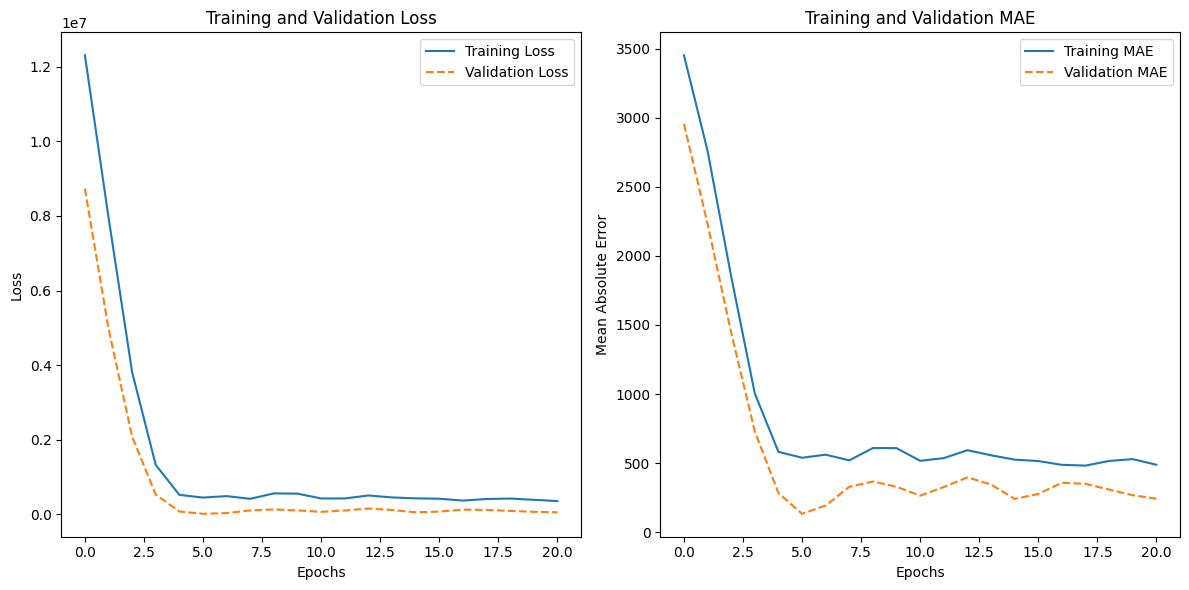

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
[[3704.124 ]
 [3696.7686]
 [3690.4382]
 [3689.4482]
 [3683.1987]]


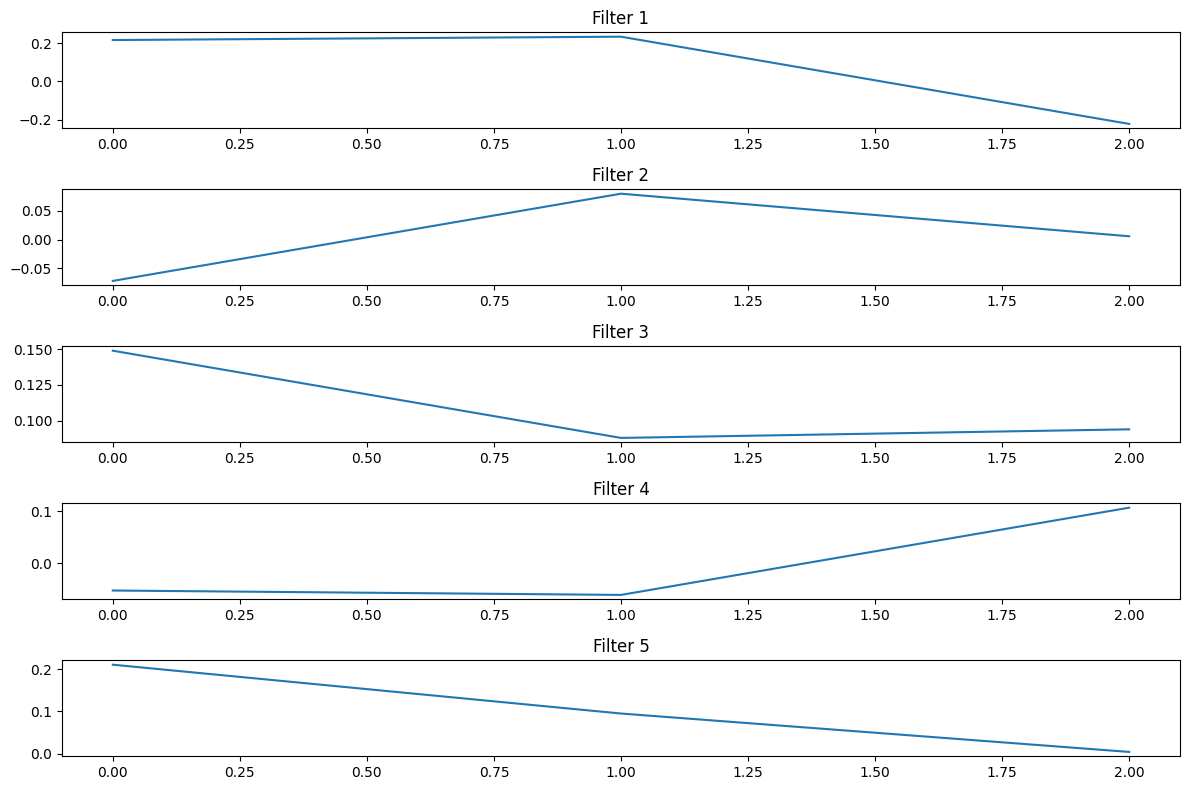

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf

# Fetch 30-minute interval data for Ethereum (ETH) against USD
symbol = "ETH-USD"
data = yf.download(symbol, interval="30m", period="5d")  # Fetch 5 days of data with 30-minute interval

# Ensure we have enough data (at least 10 time steps for the model)
if len(data) < 10:
    raise ValueError("Not enough data fetched for the model.")

# Extract the 'Close' price to use as our feature
prices = data['Close'].values

# Prepare the data (reshape it into (num_samples, 10, 1))
X = []
y = []

# We will use the 'Close' price as the feature and predict the next price (simplified task)
for i in range(len(prices) - 10):
    X.append(prices[i:i + 10])  # Use 10 previous prices to predict the next one
    y.append(prices[i + 10])    # The next price will be the target (regression task)

# Convert to numpy arrays and reshape X to have 1 feature
X = np.array(X).reshape(-1, 10, 1)
y = np.array(y)

# Define the model with Input layer
input_layer = layers.Input(shape=(10, 1))  # Input layer

# First block of convolutions
x1 = layers.Conv1D(32, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(input_layer)  # Increased filters and L2 regularization
x1 = BatchNormalization()(x1)  # BatchNormalization after the Conv1D layer
x2 = layers.Conv1D(32, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x1)  # Increased filters and L2 regularization
x2 = BatchNormalization()(x2)  # BatchNormalization after the Conv1D layer

# Residual connection (matching the shapes before adding)
x1_res = layers.Conv1D(32, 1, padding='same', kernel_regularizer=l2(0.01))(input_layer)  # Matching the shape of x2 with padding
residual = layers.Add()([x2, x1_res])  # Adding the residual connection
x1_out = layers.ReLU()(residual)
x1_out = layers.Dropout(0.3)(x1_out)  # Increased dropout to prevent overfitting

# Second block of convolutions
x3 = layers.Conv1D(32, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x1_out)  # Increased filters and L2 regularization
x3 = BatchNormalization()(x3)  # BatchNormalization after the Conv1D layer
x4 = layers.Conv1D(32, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x3)  # Increased filters and L2 regularization
x4 = BatchNormalization()(x4)  # BatchNormalization after the Conv1D layer

# Residual connection (matching the shapes before adding)
x3_res = layers.Conv1D(32, 1, padding='same', kernel_regularizer=l2(0.01))(x1_out)  # Matching the shape of x4 with padding
residual2 = layers.Add()([x4, x3_res])  # Adding the residual connection
x2_out = layers.ReLU()(residual2)
x2_out = layers.Dropout(0.3)(x2_out)  # Increased dropout to prevent overfitting

# Flattening and Dense layer
x3_out = layers.Flatten()(x2_out)
output = layers.Dense(1)(x3_out)  # Predicting the next price (regression task)

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Model summary
model.summary()

# Compile the model with adjusted learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model and capture the training history
history = model.fit(X, y, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Plotting the training loss and MAE
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Make predictions
predictions = model.predict(X)

# Print some predictions
print(predictions[:5])  # Print the first 5 predictions

# Visualize the learned filters of the first Conv1D layer (Simplified)
filters = model.layers[1].get_weights()[0]  # First Conv1D layer weights
num_filters = filters.shape[2]

# Limit the number of filters to display for simplicity
num_filters_to_display = min(num_filters, 5)  # Show at most 5 filters

plt.figure(figsize=(12, 8))
for i in range(num_filters_to_display):
    plt.subplot(num_filters_to_display, 1, i + 1)
    plt.plot(filters[:, 0, i])  # Plot each filter's weights
    plt.title(f"Filter {i + 1}")
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_92 (Conv1D)        │ (None, 10, 32)         │            128 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_93 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_92[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_94 (Conv1D)        │ (None, 10, 32)         │             64 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_31 (Add)              │ (None, 10, 32)         │              0 │ conv1d_93[0][0],       │
│                           │                        │                │ conv1d_94[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_28 (ReLU)           │ (None, 10, 32)         │              0 │ add_31[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_28 (Dropout)      │ (None, 10, 32)         │              0 │ re_lu_28[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_95 (Conv1D)        │ (None, 10, 32)         │          3,104 │ dropout_28[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_96 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_95[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_97 (Conv1D)        │ (None, 10, 32)         │          1,056 │ dropout_28[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_32 (Add)              │ (None, 10, 32)         │              0 │ conv1d_96[0][0],       │
│                           │                        │                │ conv1d_97[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_29 (ReLU)           │ (None, 10, 32)         │              0 │ add_32[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_29 (Dropout)      │ (None, 10, 32)         │              0 │ re_lu_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_11 (Flatten)      │ (None, 320)            │              0 │ dropout_29[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │            321 │ flatten_11[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,881 (42.50 KB)

 Trainable params: 10,881 (42.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9200405.0000 - mae: 2911.1106 - val_loss: 1402306.7500 - val_mae: 1183.6367
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1268358.5000 - mae: 927.6370 - val_loss: 180854.4844 - val_mae: 423.7717
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 940414.5000 - mae: 754.9650 - val_loss: 5951.1714 - val_mae: 69.7837
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 671650.0625 - mae: 638.6929 - val_loss: 152623.0469 - val_mae: 389.1602
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 753036.5625 - mae: 676.2195 - val_loss: 24421.5000 - val_mae: 152.4977
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 542888.7500 - mae: 573.2561 - val_loss: 8801.4854 - val_mae: 87.5239
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 752581.6250 - mae: 691.6205 - val_loss: 60768.3203 - val_mae: 244.2011
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 559179.4375 - mae: 600.436

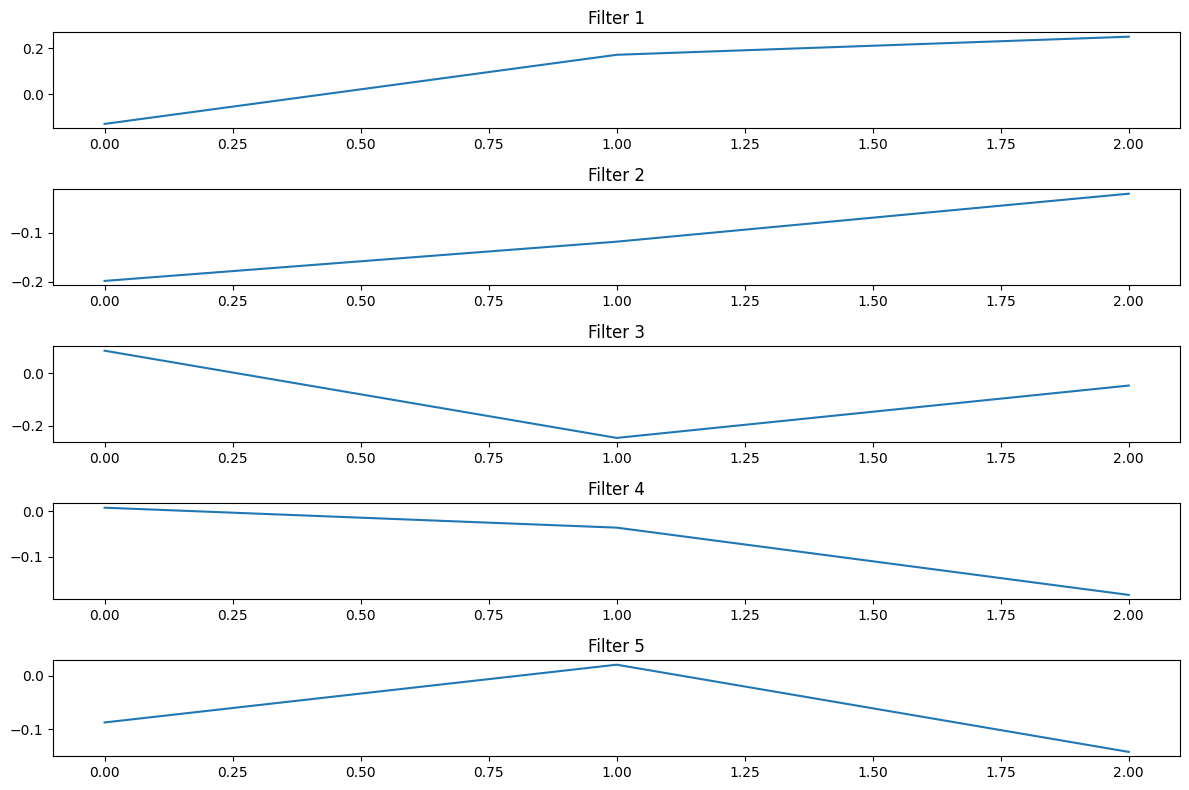

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[3781.2874]
 [3777.0063]
 [3763.37  ]
 [3764.649 ]
 [3768.426 ]]


In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Fetch 30-minute interval data for Ethereum (ETH) against USD
symbol = "ETH-USD"
data = yf.download(symbol, interval="30m", period="5d")  # Fetch 5 days of data with 30-minute interval

# Ensure we have enough data (at least 10 time steps for the model)
if len(data) < 10:
    raise ValueError("Not enough data fetched for the model.")

# Extract the 'Close' price to use as our feature
prices = data['Close'].values

# Prepare the data (reshape it into (num_samples, 10, 1))
X = []
y = []

# We will use the 'Close' price as the feature and predict the next price (simplified task)
for i in range(len(prices) - 10):
    X.append(prices[i:i + 10])  # Use 10 previous prices to predict the next one
    y.append(prices[i + 10])    # The next price will be the target (regression task)

# Convert to numpy arrays and reshape X to have 1 feature
X = np.array(X).reshape(-1, 10, 1)
y = np.array(y)

# Define the model with Input layer
input_layer = layers.Input(shape=(10, 1))  # Input layer

# First block of convolutions
x1 = layers.Conv1D(32, 3, activation='relu', padding='same')(input_layer)  # Padding to keep sequence length
x2 = layers.Conv1D(32, 3, activation='relu', padding='same')(x1)  # Padding to keep sequence length

# Residual connection (matching the shapes before adding)
x1_res = layers.Conv1D(32, 1, padding='same')(input_layer)  # Matching the shape of x2 with padding
residual = layers.Add()([x2, x1_res])  # Adding the residual connection
x1_out = layers.ReLU()(residual)
x1_out = layers.Dropout(0.2)(x1_out)

# Second block of convolutions
x3 = layers.Conv1D(32, 3, activation='relu', padding='same')(x1_out)  # Padding to keep sequence length
x4 = layers.Conv1D(32, 3, activation='relu', padding='same')(x3)  # Padding to keep sequence length

# Residual connection (matching the shapes before adding)
x3_res = layers.Conv1D(32, 1, padding='same')(x1_out)  # Matching the shape of x4 with padding
residual2 = layers.Add()([x4, x3_res])  # Adding the residual connection
x2_out = layers.ReLU()(residual2)
x2_out = layers.Dropout(0.2)(x2_out)

# Flattening and Dense layer
x3_out = layers.Flatten()(x2_out)
output = layers.Dense(1)(x3_out)  # Predicting the next price (regression task)

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Model summary
model.summary()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model (using the example data)
history = model.fit(X, y, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Visualize the learned filters of the first Conv1D layer (Simplified)
filters = model.layers[1].get_weights()[0]  # First Conv1D layer weights
num_filters = filters.shape[2]

# Limit the number of filters to display for simplicity
num_filters_to_display = min(num_filters, 5)  # Show at most 5 filters

plt.figure(figsize=(12, 8))
for i in range(num_filters_to_display):
    plt.subplot(num_filters_to_display, 1, i + 1)
    plt.plot(filters[:, 0, i])  # Plot each filter's weights
    plt.title(f"Filter {i + 1}")
plt.tight_layout()
plt.show()

# Make predictions
predictions = model.predict(X)

# Print some predictions
print(predictions[:5])  # Print the first 5 predictions

[*********************100%***********************]  1 of 1 completed


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_98 (Conv1D)        │ (None, 10, 32)         │            128 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_99 (Conv1D)        │ (None, 10, 32)         │          3,104 │ conv1d_98[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_100 (Conv1D)       │ (None, 10, 32)         │             64 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_33 (Add)              │ (None, 10, 32)         │              0 │ conv1d_99[0][0],       │
│                           │                        │                │ conv1d_100[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_30 (ReLU)           │ (None, 10, 32)         │              0 │ add_33[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_30 (Dropout)      │ (None, 10, 32)         │              0 │ re_lu_30[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_101 (Conv1D)       │ (None, 10, 32)         │          3,104 │ dropout_30[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_102 (Conv1D)       │ (None, 10, 32)         │          3,104 │ conv1d_101[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_103 (Conv1D)       │ (None, 10, 32)         │          1,056 │ dropout_30[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_34 (Add)              │ (None, 10, 32)         │              0 │ conv1d_102[0][0],      │
│                           │                        │                │ conv1d_103[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_31 (ReLU)           │ (None, 10, 32)         │              0 │ add_34[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_31 (Dropout)      │ (None, 10, 32)         │              0 │ re_lu_31[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_12 (Flatten)      │ (None, 320)            │              0 │ dropout_31[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 1)              │            321 │ flatten_12[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,881 (42.50 KB)

 Trainable params: 10,881 (42.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 24506974.0000 - mae: 4785.6919 - val_loss: 5711390.5000 - val_mae: 2389.5928
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4797394.5000 - mae: 1848.4268 - val_loss: 36244.1133 - val_mae: 188.1568
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1286213.6250 - mae: 911.8372 - val_loss: 221352.1562 - val_mae: 469.6037
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1172234.0000 - mae: 838.5752 - val_loss: 11974.2627 - val_mae: 105.5993
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1087899.1250 - mae: 844.5964 - val_loss: 17995.6621 - val_mae: 131.0393
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 735806.2500 - mae: 681.3725 - val_loss: 21859.2480 - val_mae: 145.0893
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 696324.1875 - mae: 666.5206 - val_loss: 889.6246 - val_mae: 22.7161
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 661054.6875 - mae: 

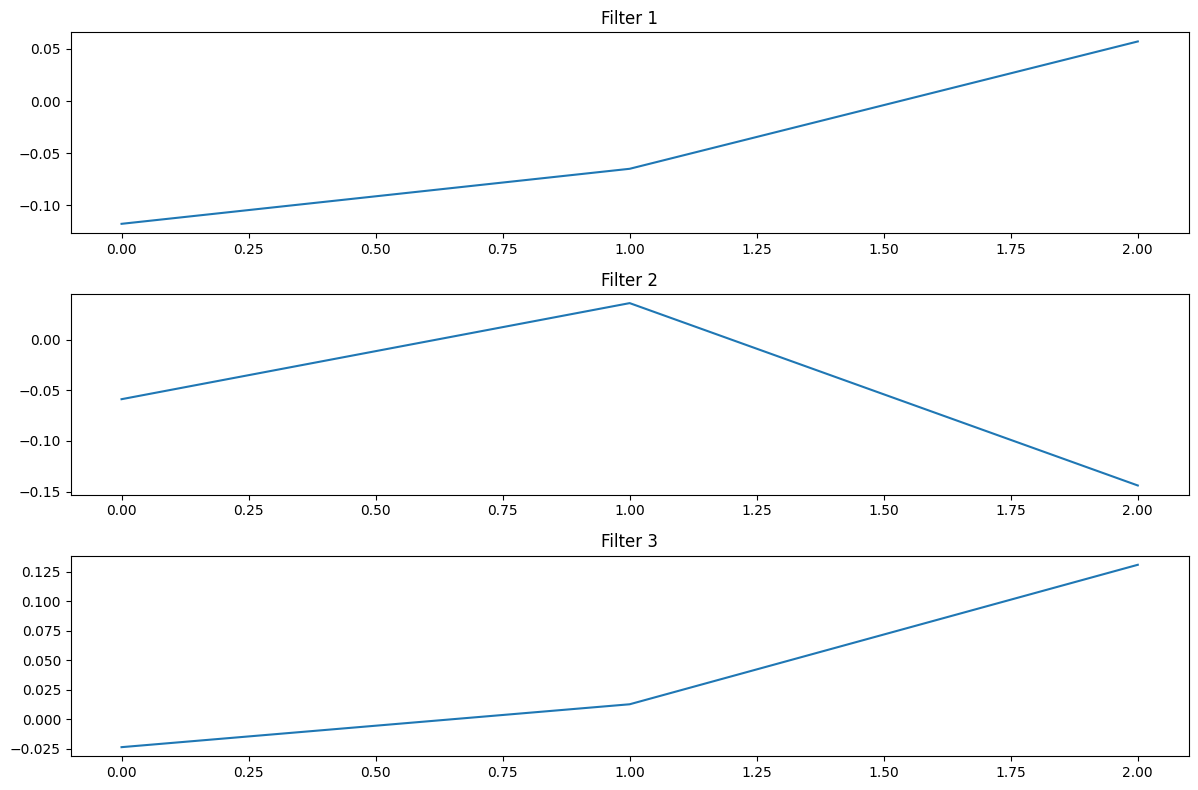

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[3862.7722]
 [3857.8752]
 [3859.8152]
 [3850.4553]
 [3850.4744]]


In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Fetch 30-minute interval data for Ethereum (ETH) against USD
symbol = "ETH-USD"
data = yf.download(symbol, interval="30m", period="5d")  # Fetch 5 days of data with 30-minute interval

# Ensure we have enough data (at least 10 time steps for the model)
if len(data) < 10:
    raise ValueError("Not enough data fetched for the model.")

# Extract the 'Close' price to use as our feature
prices = data['Close'].values

# Prepare the data (reshape it into (num_samples, 10, 1))
X = []
y = []

# We will use the 'Close' price as the feature and predict the next price (simplified task)
for i in range(len(prices) - 10):
    X.append(prices[i:i + 10])  # Use 10 previous prices to predict the next one
    y.append(prices[i + 10])    # The next price will be the target (regression task)

# Convert to numpy arrays and reshape X to have 1 feature
X = np.array(X).reshape(-1, 10, 1)
y = np.array(y)

# Define the model with Input layer
input_layer = layers.Input(shape=(10, 1))  # Input layer

# First block of convolutions
x1 = layers.Conv1D(32, 3, activation='relu', padding='same')(input_layer)  # Padding to keep sequence length
x2 = layers.Conv1D(32, 3, activation='relu', padding='same')(x1)  # Padding to keep sequence length

# Residual connection (matching the shapes before adding)
x1_res = layers.Conv1D(32, 1, padding='same')(input_layer)  # Matching the shape of x2 with padding
residual = layers.Add()([x2, x1_res])  # Adding the residual connection
x1_out = layers.ReLU()(residual)
x1_out = layers.Dropout(0.2)(x1_out)

# Second block of convolutions
x3 = layers.Conv1D(32, 3, activation='relu', padding='same')(x1_out)  # Padding to keep sequence length
x4 = layers.Conv1D(32, 3, activation='relu', padding='same')(x3)  # Padding to keep sequence length

# Residual connection (matching the shapes before adding)
x3_res = layers.Conv1D(32, 1, padding='same')(x1_out)  # Matching the shape of x4 with padding
residual2 = layers.Add()([x4, x3_res])  # Adding the residual connection
x2_out = layers.ReLU()(residual2)
x2_out = layers.Dropout(0.2)(x2_out)

# Flattening and Dense layer
x3_out = layers.Flatten()(x2_out)
output = layers.Dense(1)(x3_out)  # Predicting the next price (regression task)

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Model summary
model.summary()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model (using the example data)
history = model.fit(X, y, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Visualize the learned filters of the first Conv1D layer (Simplified)
filters = model.layers[1].get_weights()[0]  # First Conv1D layer weights
num_filters = filters.shape[2]

# Limit the number of filters to display for simplicity
num_filters_to_display = 3  # Show only 3 filters

plt.figure(figsize=(12, 8))
for i in range(num_filters_to_display):
    plt.subplot(num_filters_to_display, 1, i + 1)
    plt.plot(filters[:, 0, i])  # Plot each filter's weights
    plt.title(f"Filter {i + 1}")
plt.tight_layout()
plt.show()

# Make predictions
predictions = model.predict(X)

# Print some predictions
print(predictions[:5])  # Print the first 5 predictions

[*********************100%***********************]  1 of 1 completed


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_104 (Conv1D)       │ (None, 10, 128)        │            512 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 10, 128)        │            512 │ conv1d_104[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_105 (Conv1D)       │ (None, 10, 128)        │         49,280 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 10, 128)        │            512 │ conv1d_105[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_106 (Conv1D)       │ (None, 10, 128)        │            256 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_35 (Add)              │ (None, 10, 128)        │              0 │ batch_normalization_1… │
│                           │                        │                │ conv1d_106[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_32 (ReLU)           │ (None, 10, 128)        │              0 │ add_35[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_32 (Dropout)      │ (None, 10, 128)        │              0 │ re_lu_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_107 (Conv1D)       │ (None, 10, 128)        │         49,280 │ dropout_32[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 10, 128)        │            512 │ conv1d_107[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_108 (Conv1D)       │ (None, 10, 128)        │         49,280 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 10, 128)        │            512 │ conv1d_108[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_109 (Conv1D)       │ (None, 10, 128)        │         16,512 │ dropout_32[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_36 (Add)              │ (None, 10, 128)        │              0 │ batch_normalization_1… │
│                           │                        │                │ conv1d_109[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_33 (ReLU)           │ (None, 10, 128)        │              0 │ add_36[0][0]           │
├──────────────────────

 Total params: 168,449 (658.00 KB)

 Trainable params: 167,425 (654.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 7689459.5000 - mae: 2704.9553 - val_loss: 1217951.8750 - val_mae: 1103.1466
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 642033.8750 - mae: 687.0386 - val_loss: 230639.5156 - val_mae: 479.2992
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 646936.8125 - mae: 713.2421 - val_loss: 26093.3594 - val_mae: 158.6447
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 193581.0469 - mae: 372.0238 - val_loss: 143267.2500 - val_mae: 377.2666
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 167579.1406 - mae: 333.4384 - val_loss: 23658.1992 - val_mae: 150.7825
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 130716.5625 - mae: 291.2256 - val_loss: 17000.8770 - val_mae: 126.8095
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 134384.9375 - mae: 293.6255 - val_loss: 61724.6641 - val_mae: 246.5749
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 158278.7812 - ma

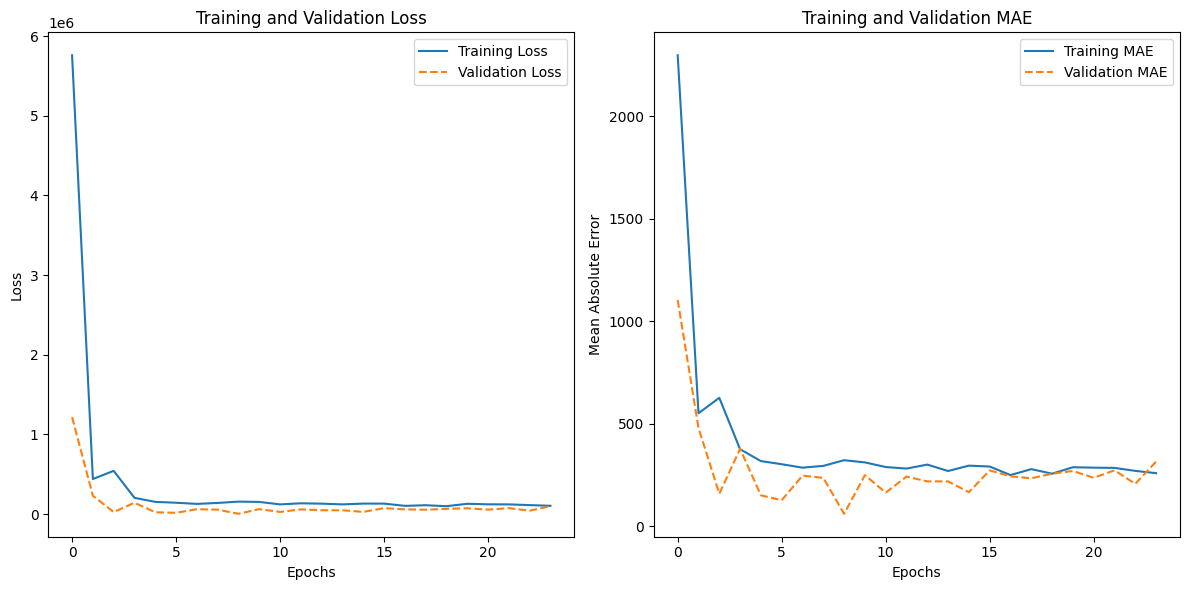

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[3787.4038]
 [3785.2463]
 [3780.1887]
 [3774.0618]
 [3775.6868]]


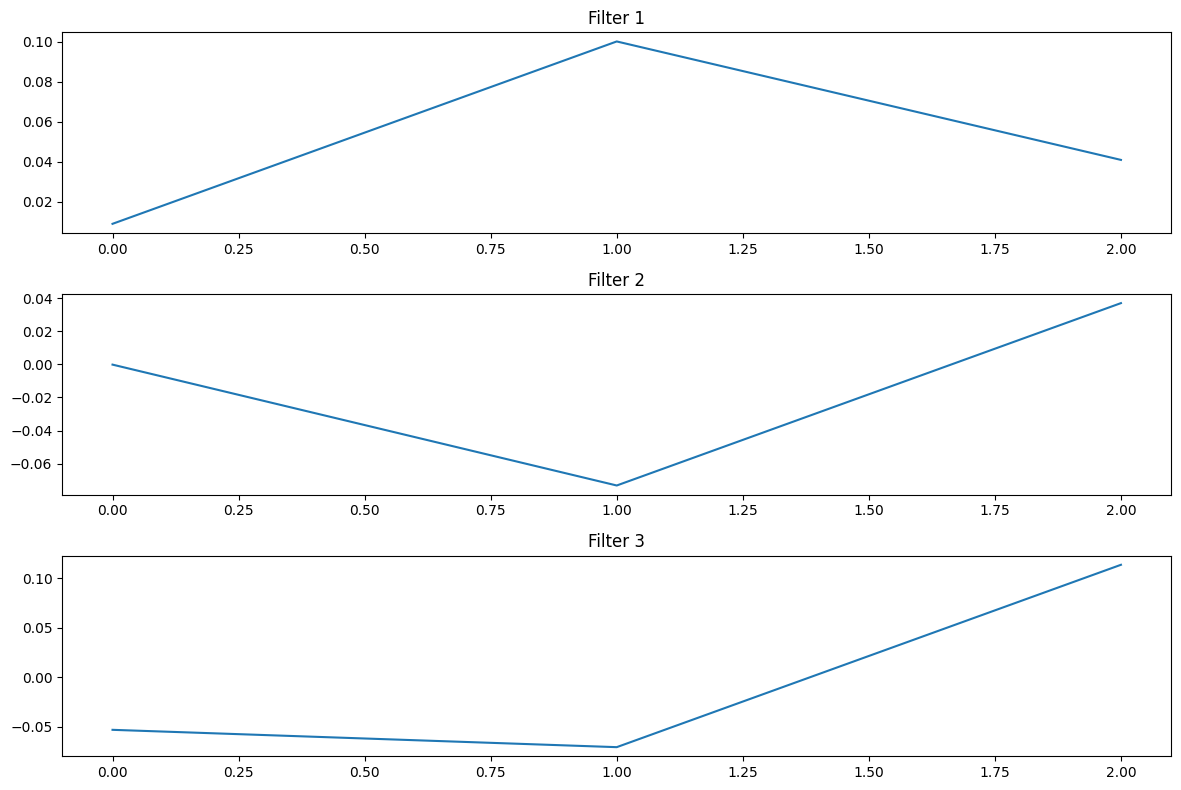

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf

# Fetch 30-minute interval data for Ethereum (ETH) against USD
symbol = "ETH-USD"
data = yf.download(symbol, interval="30m", period="5d")  # Fetch 5 days of data with 30-minute interval

# Ensure we have enough data (at least 10 time steps for the model)
if len(data) < 10:
    raise ValueError("Not enough data fetched for the model.")

# Extract the 'Close' price to use as our feature
prices = data['Close'].values

# Prepare the data (reshape it into (num_samples, 10, 1))
X = []
y = []

# We will use the 'Close' price as the feature and predict the next price (simplified task)
for i in range(len(prices) - 10):
    X.append(prices[i:i + 10])  # Use 10 previous prices to predict the next one
    y.append(prices[i + 10])    # The next price will be the target (regression task)

# Convert to numpy arrays and reshape X to have 1 feature
X = np.array(X).reshape(-1, 10, 1)
y = np.array(y)

# Define the model with Input layer
input_layer = layers.Input(shape=(10, 1))  # Input layer

# First block of convolutions
x1 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(input_layer)  # Increased filters and L2 regularization
x1 = BatchNormalization()(x1)  # BatchNormalization after the Conv1D layer
x2 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x1)  # Increased filters and L2 regularization
x2 = BatchNormalization()(x2)  # BatchNormalization after the Conv1D layer

# Residual connection (matching the shapes before adding)
x1_res = layers.Conv1D(128, 1, padding='same', kernel_regularizer=l2(0.01))(input_layer)  # Matching the shape of x2 with padding
residual = layers.Add()([x2, x1_res])  # Adding the residual connection
x1_out = layers.ReLU()(residual)
x1_out = layers.Dropout(0.3)(x1_out)  # Increased dropout to prevent overfitting

# Second block of convolutions
x3 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x1_out)  # Increased filters and L2 regularization
x3 = BatchNormalization()(x3)  # BatchNormalization after the Conv1D layer
x4 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x3)  # Increased filters and L2 regularization
x4 = BatchNormalization()(x4)  # BatchNormalization after the Conv1D layer

# Residual connection (matching the shapes before adding)
x3_res = layers.Conv1D(128, 1, padding='same', kernel_regularizer=l2(0.01))(x1_out)  # Matching the shape of x4 with padding
residual2 = layers.Add()([x4, x3_res])  # Adding the residual connection
x2_out = layers.ReLU()(residual2)
x2_out = layers.Dropout(0.3)(x2_out)  # Increased dropout to prevent overfitting

# Flattening and Dense layer
x3_out = layers.Flatten()(x2_out)
output = layers.Dense(1)(x3_out)  # Predicting the next price (regression task)

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Model summary
model.summary()

# Compile the model with adjusted learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model and capture the training history
history = model.fit(X, y, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Plotting the training loss and MAE
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Make predictions
predictions = model.predict(X)

# Print some predictions
print(predictions[:5])  # Print the first 5 predictions

# Visualize the learned filters of the first Conv1D layer (Simplified)
filters = model.layers[1].get_weights()[0]  # First Conv1D layer weights
num_filters = filters.shape[2]

# Limit the number of filters to display for simplicity (show only 3 filters)
num_filters_to_display = min(num_filters, 3)  # Show at most 3 filters

plt.figure(figsize=(12, 8))
for i in range(num_filters_to_display):
    plt.subplot(num_filters_to_display, 1, i + 1)
    plt.plot(filters[:, 0, i])  # Plot each filter's weights
    plt.title(f"Filter {i + 1}")
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20            │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_128 (Conv1D)       │ (None, 10, 128)        │            512 │ input_layer_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 10, 128)        │            512 │ conv1d_128[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_129 (Conv1D)       │ (None, 10, 128)        │         49,280 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_29    │ (None, 10, 128)        │            512 │ conv1d_129[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_130 (Conv1D)       │ (None, 10, 128)        │            256 │ input_layer_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_43 (Add)              │ (None, 10, 128)        │              0 │ batch_normalization_2… │
│                           │                        │                │ conv1d_130[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_40 (ReLU)           │ (None, 10, 128)        │              0 │ add_43[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_40 (Dropout)      │ (None, 10, 128)        │              0 │ re_lu_40[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_131 (Conv1D)       │ (None, 10, 128)        │         49,280 │ dropout_40[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 10, 128)        │            512 │ conv1d_131[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_132 (Conv1D)       │ (None, 10, 128)        │         49,280 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, 10, 128)        │            512 │ conv1d_132[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_133 (Conv1D)       │ (None, 10, 128)        │         16,512 │ dropout_40[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_44 (Add)              │ (None, 10, 128)        │              0 │ batch_normalization_3… │
│                           │                        │                │ conv1d_133[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_41 (ReLU)           │ (None, 10, 128)        │              0 │ add_44[0][0]           │
├──────────────────────

 Total params: 168,449 (658.00 KB)

 Trainable params: 167,425 (654.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 6158464.5000 - mae: 2030.0483 - val_loss: 31913.2227 - val_mae: 177.9527
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 133115.1719 - mae: 292.1077 - val_loss: 41340.1133 - val_mae: 202.7119
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 136590.4844 - mae: 297.9670 - val_loss: 89288.2656 - val_mae: 298.3917
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 122452.1797 - mae: 277.9467 - val_loss: 63482.4727 - val_mae: 251.4602
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 107793.4531 - mae: 261.2410 - val_loss: 86839.8984 - val_mae: 294.2573
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 97679.4844 - mae: 252.2832 - val_loss: 88423.7266 - val_mae: 296.9359
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 96229.5156 - mae: 238.0496 - val_loss: 121116.4219 - val_mae: 347.6506
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 78877.9844 - mae: 225.

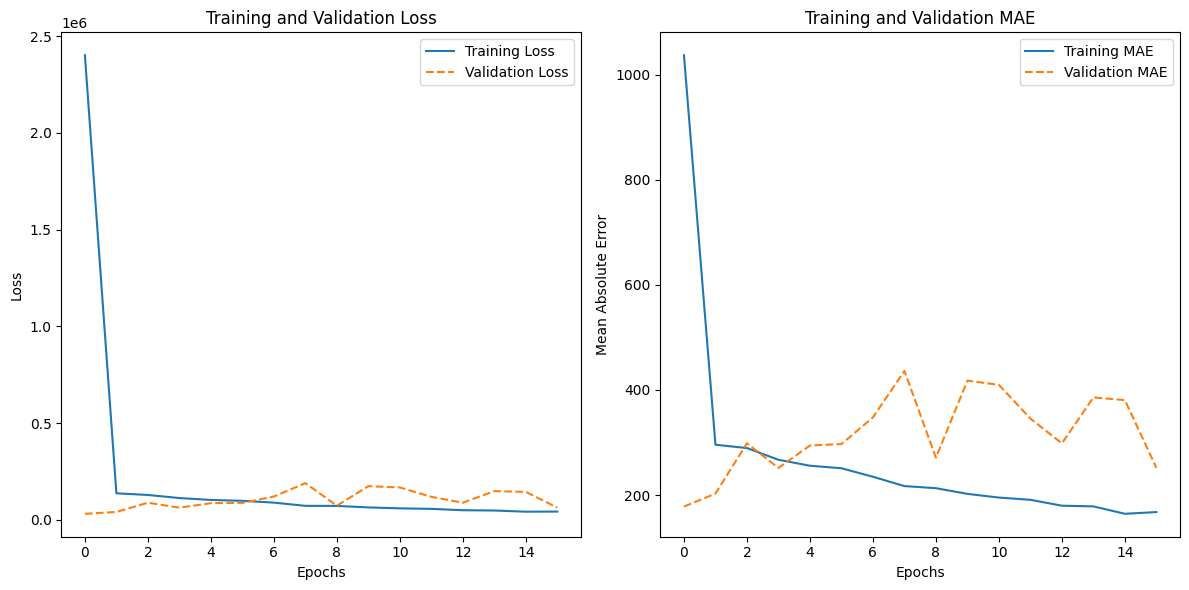

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[3675.0747]
 [3676.3904]
 [3676.106 ]
 [3676.0278]
 [3674.2502]]


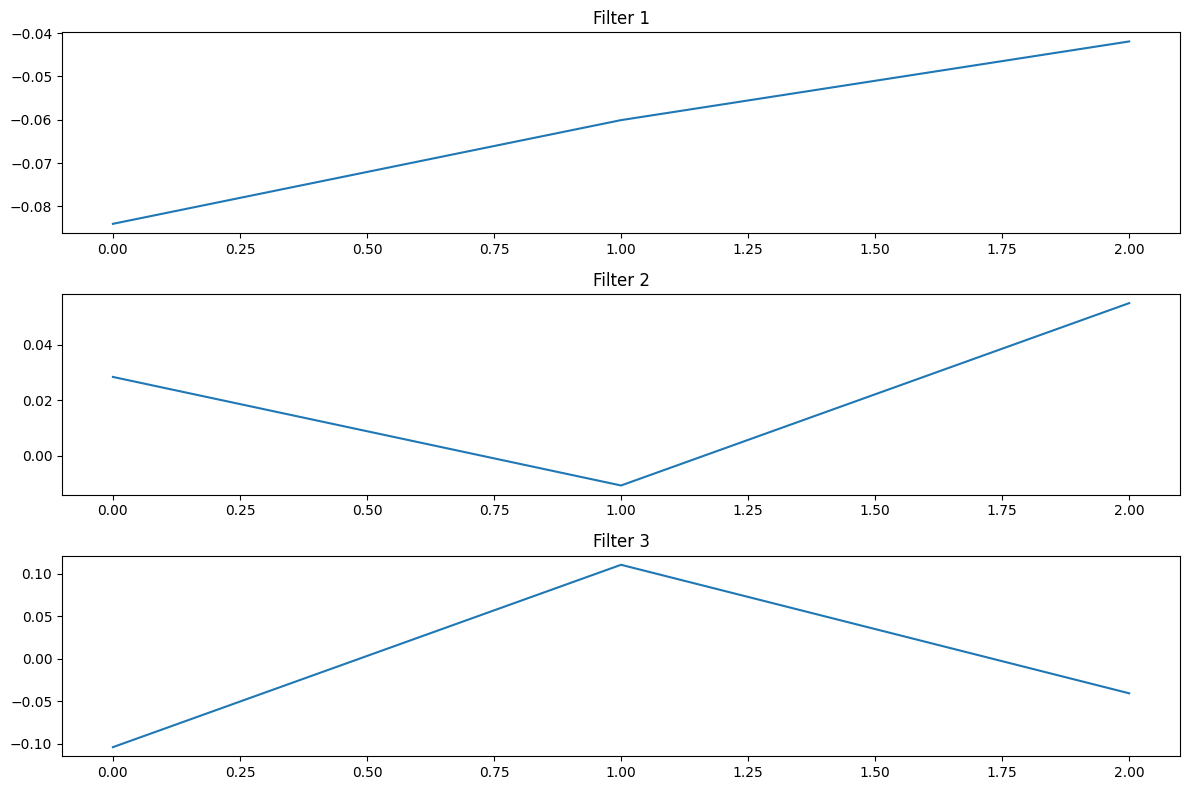

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf

# Fetch 5-minute interval data for Ethereum (ETH) against USD
symbol = "ETH-USD"
data = yf.download(symbol, interval="5m", period="5d")  # Fetch 5 days of data with 5-minute interval

# Ensure we have enough data (at least 10 time steps for the model)
if len(data) < 10:
    raise ValueError("Not enough data fetched for the model.")

# Extract the 'Close' price to use as our feature
prices = data['Close'].values

# Prepare the data (reshape it into (num_samples, 10, 1))
X = []
y = []

# We will use the 'Close' price as the feature and predict the next price (simplified task)
for i in range(len(prices) - 10):
    X.append(prices[i:i + 10])  # Use 10 previous prices to predict the next one
    y.append(prices[i + 10])    # The next price will be the target (regression task)

# Convert to numpy arrays and reshape X to have 1 feature
X = np.array(X).reshape(-1, 10, 1)
y = np.array(y)

# Define the model with Input layer
input_layer = layers.Input(shape=(10, 1))  # Input layer

# First block of convolutions
x1 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(input_layer)  # Increased filters and L2 regularization
x1 = BatchNormalization()(x1)  # BatchNormalization after the Conv1D layer
x2 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x1)  # Increased filters and L2 regularization
x2 = BatchNormalization()(x2)  # BatchNormalization after the Conv1D layer

# Residual connection (matching the shapes before adding)
x1_res = layers.Conv1D(128, 1, padding='same', kernel_regularizer=l2(0.01))(input_layer)  # Matching the shape of x2 with padding
residual = layers.Add()([x2, x1_res])  # Adding the residual connection
x1_out = layers.ReLU()(residual)
x1_out = layers.Dropout(0.3)(x1_out)  # Increased dropout to prevent overfitting

# Second block of convolutions
x3 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x1_out)  # Increased filters and L2 regularization
x3 = BatchNormalization()(x3)  # BatchNormalization after the Conv1D layer
x4 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x3)  # Increased filters and L2 regularization
x4 = BatchNormalization()(x4)  # BatchNormalization after the Conv1D layer

# Residual connection (matching the shapes before adding)
x3_res = layers.Conv1D(128, 1, padding='same', kernel_regularizer=l2(0.01))(x1_out)  # Matching the shape of x4 with padding
residual2 = layers.Add()([x4, x3_res])  # Adding the residual connection
x2_out = layers.ReLU()(residual2)
x2_out = layers.Dropout(0.3)(x2_out)  # Increased dropout to prevent overfitting

# Flattening and Dense layer
x3_out = layers.Flatten()(x2_out)
output = layers.Dense(1)(x3_out)  # Predicting the next price (regression task)

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Model summary
model.summary()

# Compile the model with adjusted learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model and capture the training history
history = model.fit(X, y, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Plotting the training loss and MAE
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Make predictions
predictions = model.predict(X)

# Print some predictions
print(predictions[:5])  # Print the first 5 predictions

# Visualize the learned filters of the first Conv1D layer (Simplified)
filters = model.layers[1].get_weights()[0]  # First Conv1D layer weights
num_filters = filters.shape[2]

# Limit the number of filters to display for simplicity (show only 3 filters)
num_filters_to_display = min(num_filters, 3)  # Show at most 3 filters

plt.figure(figsize=(12, 8))
for i in range(num_filters_to_display):
    plt.subplot(num_filters_to_display, 1, i + 1)
    plt.plot(filters[:, 0, i])  # Plot each filter's weights
    plt.title(f"Filter {i + 1}")
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 10, 128)        │            512 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 10, 128)        │            512 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 10, 128)        │         49,280 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 10, 128)        │            512 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 10, 128)        │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 10, 128)        │              0 │ batch_normalization_1… │
│                           │                        │                │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 10, 128)        │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 10, 128)        │              0 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 10, 128)        │         49,280 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 10, 128)        │            512 │ conv1d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 10, 128)        │         49,280 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 10, 128)        │            512 │ conv1d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 10, 128)        │         16,512 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 10, 128)        │              0 │ batch_normalization_3… │
│                           │                        │                │ conv1d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 10, 128)        │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 168,449 (658.00 KB)

 Trainable params: 167,425 (654.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 4321278.5000 - mae: 1671.8053 - val_loss: 34416.0859 - val_mae: 184.5920
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 141210.0469 - mae: 294.5192 - val_loss: 45025.4609 - val_mae: 211.3860
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 129964.0938 - mae: 292.1404 - val_loss: 53184.1562 - val_mae: 229.8683
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 106969.0859 - mae: 264.6842 - val_loss: 46702.1250 - val_mae: 215.3074
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 100989.7578 - mae: 249.2346 - val_loss: 57245.4297 - val_mae: 238.5413
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 89547.8516 - mae: 238.5466 - val_loss: 59405.1992 - val_mae: 243.0255
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 71268.3828 - mae: 212.5356 - val_loss: 87860.6953 - val_mae: 295.8339
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 66176.8438 - mae: 208.

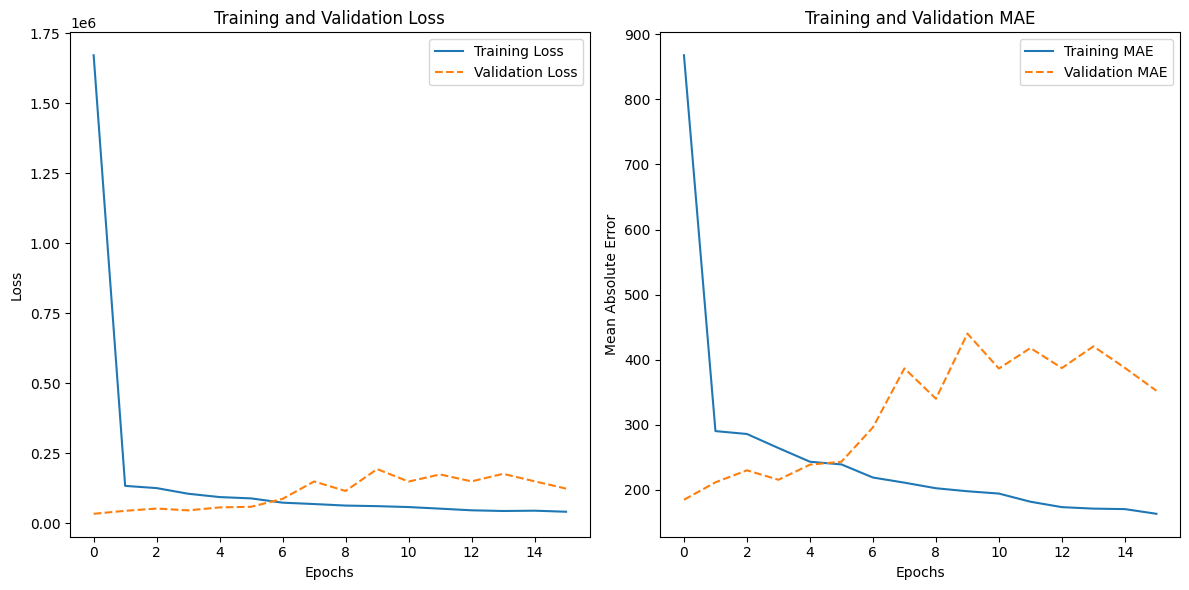

Time before prediction: 2024-12-23 09:16:32
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Time after prediction: 2024-12-23 09:16:33
[[3444.9834]
 [3444.9233]
 [3445.15  ]
 [3443.475 ]
 [3442.727 ]]


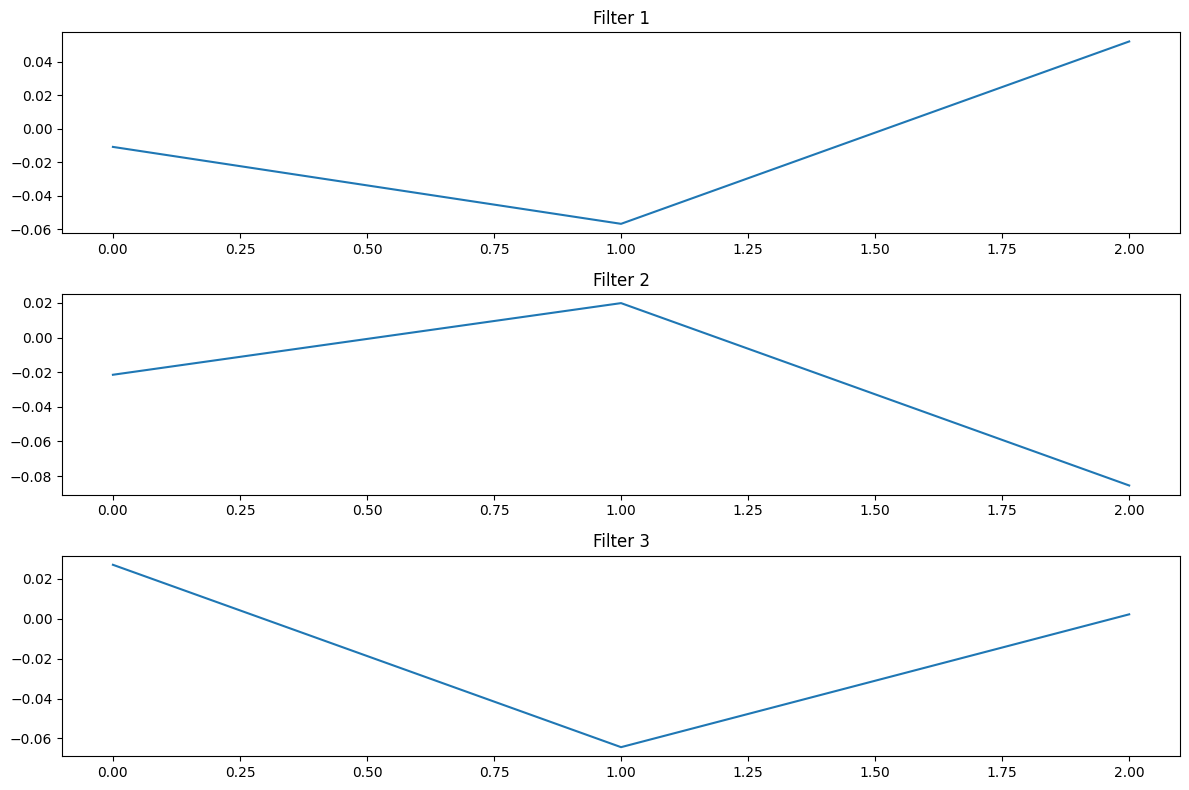

In [ ]:

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
import datetime

# Fetch 5-minute interval data for Ethereum (ETH) against USD
symbol = "ETH-USD"
data = yf.download(symbol, interval="5m", period="5d")  # Fetch 5 days of data with 5-minute interval

# Ensure we have enough data (at least 10 time steps for the model)
if len(data) < 10:
    raise ValueError("Not enough data fetched for the model.")

# Extract the 'Close' price to use as our feature
prices = data['Close'].values

# Prepare the data (reshape it into (num_samples, 10, 1))
X = []
y = []

# We will use the 'Close' price as the feature and predict the next price (simplified task)
for i in range(len(prices) - 10):
    X.append(prices[i:i + 10])  # Use 10 previous prices to predict the next one
    y.append(prices[i + 10])    # The next price will be the target (regression task)

# Convert to numpy arrays and reshape X to have 1 feature
X = np.array(X).reshape(-1, 10, 1)
y = np.array(y)

# Define the model with Input layer
input_layer = layers.Input(shape=(10, 1))  # Input layer

# First block of convolutions
x1 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(input_layer)  # Increased filters and L2 regularization
x1 = BatchNormalization()(x1)  # BatchNormalization after the Conv1D layer
x2 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x1)  # Increased filters and L2 regularization
x2 = BatchNormalization()(x2)  # BatchNormalization after the Conv1D layer

# Residual connection (matching the shapes before adding)
x1_res = layers.Conv1D(128, 1, padding='same', kernel_regularizer=l2(0.01))(input_layer)  # Matching the shape of x2 with padding
residual = layers.Add()([x2, x1_res])  # Adding the residual connection
x1_out = layers.ReLU()(residual)
x1_out = layers.Dropout(0.3)(x1_out)  # Increased dropout to prevent overfitting

# Second block of convolutions
x3 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x1_out)  # Increased filters and L2 regularization
x3 = BatchNormalization()(x3)  # BatchNormalization after the Conv1D layer
x4 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x3)  # Increased filters and L2 regularization
x4 = BatchNormalization()(x4)  # BatchNormalization after the Conv1D layer

# Residual connection (matching the shapes before adding)
x3_res = layers.Conv1D(128, 1, padding='same', kernel_regularizer=l2(0.01))(x1_out)  # Matching the shape of x4 with padding
residual2 = layers.Add()([x4, x3_res])  # Adding the residual connection
x2_out = layers.ReLU()(residual2)
x2_out = layers.Dropout(0.3)(x2_out)  # Increased dropout to prevent overfitting

# Flattening and Dense layer
x3_out = layers.Flatten()(x2_out)
output = layers.Dense(1)(x3_out)  # Predicting the next price (regression task)

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Model summary
model.summary()

# Compile the model with adjusted learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model and capture the training history
history = model.fit(X, y, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Plotting the training loss and MAE
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Print time before prediction
print("\033[1mTime before prediction:\033[0m", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# Make predictions
predictions = model.predict(X)

# Print time after prediction
print("\033[1mTime after prediction:\033[0m", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# Print some predictions
print(predictions[:5])  # Print the first 5 predictions

# Visualize the learned filters of the first Conv1D layer (Simplified)
filters = model.layers[1].get_weights()[0]  # First Conv1D layer weights
num_filters = filters.shape[2]

# Limit the number of filters to display for simplicity (show only 3 filters)
num_filters_to_display = min(num_filters, 3)  # Show at most 3 filters

plt.figure(figsize=(12, 8))
for i in range(num_filters_to_display):
    plt.subplot(num_filters_to_display, 1, i + 1)
    plt.plot(filters[:, 0, i])  # Plot each filter's weights
    plt.title(f"Filter {i + 1}")
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 10, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 10, 128)        │            512 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 10, 128)        │            512 │ conv1d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 10, 128)        │         49,280 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 10, 128)        │            512 │ conv1d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 10, 128)        │            256 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 10, 128)        │              0 │ batch_normalization_5… │
│                           │                        │                │ conv1d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 10, 128)        │              0 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 10, 128)        │              0 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 10, 128)        │         49,280 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 10, 128)        │            512 │ conv1d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 10, 128)        │         49,280 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 10, 128)        │            512 │ conv1d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 10, 128)        │         16,512 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 10, 128)        │              0 │ batch_normalization_7… │
│                           │                        │                │ conv1d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 10, 128)        │              0 │ add_3[0][0]            │
├──────────────────────

 Total params: 168,449 (658.00 KB)

 Trainable params: 167,425 (654.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 5793055.0000 - mae: 1982.2294 - val_loss: 34148.9844 - val_mae: 183.6010
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 165717.0938 - mae: 322.3325 - val_loss: 17792.5352 - val_mae: 131.7391
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 141139.6406 - mae: 300.3616 - val_loss: 32496.2539 - val_mae: 179.0844
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 109541.8906 - mae: 257.5569 - val_loss: 61014.2539 - val_mae: 246.1750
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 110250.1328 - mae: 259.5768 - val_loss: 26869.8633 - val_mae: 162.6609
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 92448.3906 - mae: 244.8160 - val_loss: 93289.4375 - val_mae: 304.7828
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 89304.7656 - mae: 239.9991 - val_loss: 44417.7930 - val_mae: 209.8080
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 79546.4766 - mae: 222.1

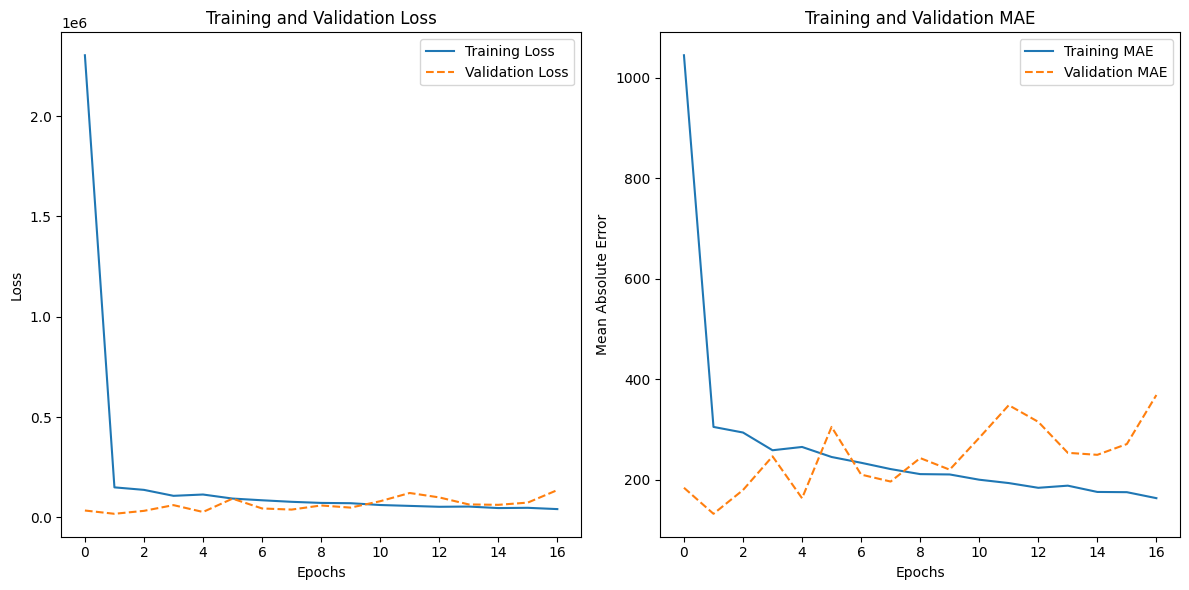

Time before prediction: 2024-12-23 09:19:04.775708
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Time after prediction: 2024-12-23 09:19:05.442462
[[3504.9631]
 [3506.1736]
 [3505.8967]
 [3505.8816]
 [3505.217 ]]


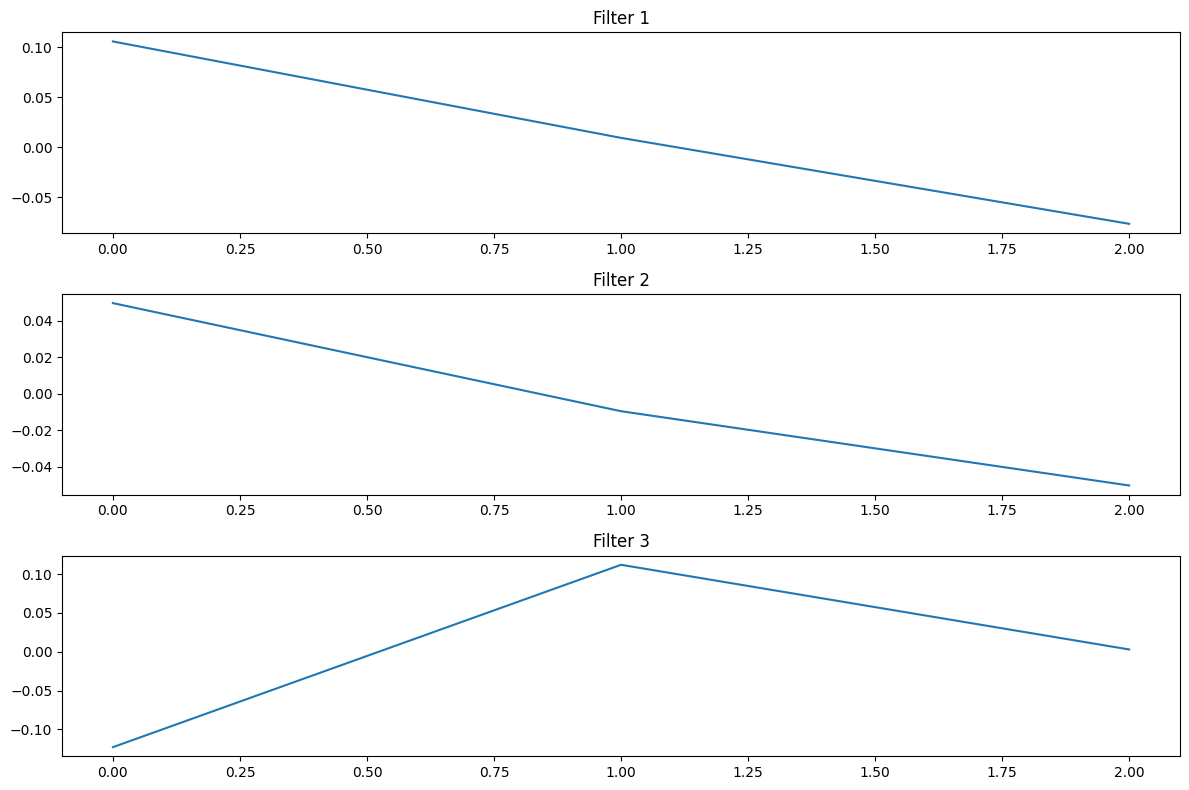

In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
import datetime

# Fetch 5-minute interval data for Ethereum (ETH) against USD
symbol = "ETH-USD"
data = yf.download(symbol, interval="5m", period="5d")  # Fetch 5 days of data with 5-minute interval

# Ensure we have enough data (at least 10 time steps for the model)
if len(data) < 10:
    raise ValueError("Not enough data fetched for the model.")

# Extract the 'Close' price to use as our feature
prices = data['Close'].values

# Prepare the data (reshape it into (num_samples, 10, 1))
X = []
y = []

# We will use the 'Close' price as the feature and predict the next price (simplified task)
for i in range(len(prices) - 10):
    X.append(prices[i:i + 10])  # Use 10 previous prices to predict the next one
    y.append(prices[i + 10])    # The next price will be the target (regression task)

# Convert to numpy arrays and reshape X to have 1 feature
X = np.array(X).reshape(-1, 10, 1)
y = np.array(y)

# Define the model with Input layer
input_layer = layers.Input(shape=(10, 1))  # Input layer

# First block of convolutions
x1 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(input_layer)
x1 = BatchNormalization()(x1)
x2 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x1)
x2 = BatchNormalization()(x2)

# Residual connection
x1_res = layers.Conv1D(128, 1, padding='same', kernel_regularizer=l2(0.01))(input_layer)
residual = layers.Add()([x2, x1_res])
x1_out = layers.ReLU()(residual)
x1_out = layers.Dropout(0.3)(x1_out)

# Second block of convolutions
x3 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x1_out)
x3 = BatchNormalization()(x3)
x4 = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.01))(x3)
x4 = BatchNormalization()(x4)

# Residual connection
x3_res = layers.Conv1D(128, 1, padding='same', kernel_regularizer=l2(0.01))(x1_out)
residual2 = layers.Add()([x4, x3_res])
x2_out = layers.ReLU()(residual2)
x2_out = layers.Dropout(0.3)(x2_out)

# Flattening and Dense layer
x3_out = layers.Flatten()(x2_out)
output = layers.Dense(1)(x3_out)  # Predicting the next price (regression task)

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Model summary
model.summary()

# Compile the model with adjusted learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model and capture the training history
history = model.fit(X, y, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Plotting the training loss and MAE
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE', linestyle='--')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Print time before prediction
print("\033[1mTime before prediction:\033[0m", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f"))

# Make predictions
predictions = model.predict(X)

# Print time after prediction
print("\033[1mTime after prediction:\033[0m", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f"))

# Print some predictions
print(predictions[:5])  # Print the first 5 predictions

# Visualize the learned filters of the first Conv1D layer (Simplified)
filters = model.layers[1].get_weights()[0]  # First Conv1D layer weights
num_filters = filters.shape[2]

# Limit the number of filters to display for simplicity (show only 3 filters)
num_filters_to_display = min(num_filters, 3)

plt.figure(figsize=(12, 8))
for i in range(num_filters_to_display):
    plt.subplot(num_filters_to_display, 1, i + 1)
    plt.plot(filters[:, 0, i])  # Plot each filter's weights
    plt.title(f"Filter {i + 1}")
plt.tight_layout()
plt.show()